In [3]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn

import NT_disk_Eqns_V1 as jscript

from os import makedirs

import pandas as pd

#some nicer code based on Test_zone.ipynb

In [6]:
def NTvsSG_disc_solver(MBH_power, spin, alpha, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    print(f'SG: {Rmin/R_G} Rg, {disk.Rmin/R_G} Rg, {disk.R[0]/R_G} Rg')

    Rout=Rmax
    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rout=Rout, Rin=Rmin, Mdot_out=Mdot_out)
    diskTQM.solve_disk()

    print(f'TQM: {Rmin/R_G} Rg, {diskTQM.Rin/R_G} Rg, {diskTQM.R[0]/R_G} Rg')

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    if save_to_file==True:
        mypath=path

        try:
            makedirs(mypath)
        except FileExistsError:
            pass

        file = open(f'{mypath}NT_inputs.txt', "w")
        file.write(f"Input Parameters:\n")
        file.write(f"version     = V1\n")
        file.write(f"log(M_SMBH) = {MBH_power}\n")
        file.write(f"spin        = {spin}\n")
        file.write(f"alpha       = {alpha}\n")
        file.write(f"mdot        = {mdot}\n")
        file.write(f"eps         = {eps}\n")
        file.write(f"le          = {le}\n")
        file.write(f"R_min       = {Rmin:.1e}\n")
        file.write(f"R_max       = {Rmax:.1e}\n")
        file.write(f"steps       = {steps}\n")
        
    Rs=[]
    sigmas=[]
    Hs=[]
    hrs=[]
    rho0s=[]
    rhos=[]
    Ts=[]

    betas=[]
    taus=[]

    flag=0
    flag2=0
    flag3=0

    r_tr=0
    r_rel=0
    r_outer=0

    inner_flag=0
    mid_flag=0
    outer_flag=0

    flag_in=0
    flag_out=0

    sf_i=0

    k=50
    if printing==True:
        print(R_oa/R_agn)
        print(f'Initial Radius = {R[k]/R_G} Rg, R_isco = {r_isco/R_G} Rg')

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)
        r_im=jscript.r_in_mid(y, MBH, spin, mdot, alpha)
        r_mo=jscript.r_mid_outer(y, MBH, spin, mdot)
        
        if printing==True:
            # print(f'Transition inner-mid = {r_im * M / R_G} Rg, Transition mid-out = {r_mo * M /R_G} Rg')
            if rstar>10*r_im and flag_in==0:
                print(f'Transition inner-mid = {r_im * M /R_G} Rg')
                flag_in=1
            if rstar>r_mo and flag_out==0:
                print(f'Transition mid-out = {r_mo * M/R_G} Rg')
                flag_out=1

        if rstar<R_im:
            if inner_flag==0:
                if printing==True:
                    print(f'disk in inner region')
                inner_flag=1
            rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT(r, MBH, spin, mdot, alpha)
            # H=jscript.H_NT(r, MBH, spin, mdot)
            H=jscript.H_NT_2(r, MBH, spin, mdot)
            sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
        
        if R_im<=rstar<R_mo:
            if mid_flag==0:
                if printing==True:
                    print(f'disk transitions to middle region at {rstar} Rg')
                mid_flag=1
            rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
        
        if R_mo<rstar:
            if outer_flag==0:
                if printing==True:
                    print(f'disk transitions to outer region at {rstar} Rg')
                outer_flag=1
            rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
        
        sigmas.append(sigma)
        Ts.append(T)
        Hs.append(H)
        rho0s.append(rho_0)
        Rs.append(rstar)

        hr=H/(100*r)

        hrs.append(hr)

        rho=sigma/(2*H)
        rhos.append(rho)

        omega=np.sqrt(ct.G * MBH / (r*r*r))

        v=omega * r
        vc=v/ct.c

        Qt= omega*omega / (2 * np.pi * ct.G * rho)

        if vc<0.1 and flag==0:
            if printing==True:
                print(f'disk stops being relativistic at {r/R_G} Rg')
            r_rel=r
            flag+=1
        
        if r>=disk.R_AGN and flag3==0:
            if printing==True:
                print(f'disk begins star formation at {r/R_G} Rg')
            sf_i=i
            r_outer=r
            flag3+=1
        
    if save_to_file==True:
        file = open(f'{mypath}NT_inputs.txt', "a")
        file.write(f"SF          = {flag3}\n")
        file.write(f"SF index    = {sf_i}\n")
        d=dict({'Radius [Rg]': Rs, 'Surface Density [gcm^-2]': sigmas, 'Temperature [K]': Ts, 'Midplane Density [gcm^-2]': rho0s, 'Thickness [cm]': Hs, 'Aspect Ratio': hrs})
        df=pd.DataFrame.from_dict(d)
        df.to_csv(f'{mypath}NT_disc.csv', index=False)

    if plotting==True:

        fig, axs = plt.subplots(1, 5, figsize=(25, 5), dpi=100)

        colour='plasma'
        cmap = plt.colormaps[colour]

        plt.suptitle(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha},'r'$\chi$ = 'f'{spin}')

        i=0

        axs[i].plot(disk.R/M, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
        axs[i].plot(diskTQM.R/M, 2*diskTQM.h*diskTQM.rho*ct.SI_to_gcm2, label = r"TQM", color=cmap(0.5))
        axs[i].plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

        i=1

        axs[i].plot(disk.R/M, disk.T, color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.T, color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$T [K] $')

        i=2

        axs[i].plot(disk.R/M, disk.rho*ct.SI_to_gcm3, color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.rho*ct.SI_to_gcm3, color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\rho [gcm^{-3}] $')

        i=3

        axs[i].plot(disk.R/M, disk.h*ct.SI_to_cms, '-', color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.h*ct.SI_to_cms, '-', color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$H [cm]$')
        axs[i].legend()

        i=4

        axs[i].plot(disk.R/M, disk.h/disk.R, '-', color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.h/diskTQM.R, '-', color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, hrs, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$H/R$')

        for i in range(0, 5):
            axs[i].axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
            axs[i].axvline(x=r_rel/M, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
            axs[i].axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
            axs[i].axvline(x=disk.R_AGN/M, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

            axs[i].set_xscale('log')
            axs[i].set_yscale('log')

            axs[i].set_xlabel("r/M")
            axs[i].set_xlim(1e0, 3e7)

        axs[i].legend()

        plt.tight_layout()
        if save_to_file==True:
            plt.savefig(f'{mypath}all_profiles_with_TQM.pdf')
        plt.show()

In [ ]:
def NTvsSG_disc_solver_smooth(MBH_power, spin, alpha, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    print(f'SG: {Rmin/R_G} Rg, {disk.Rmin/R_G} Rg, {disk.R[0]/R_G} Rg')

    Rout=Rmax
    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rout=Rout, Rin=Rmin, Mdot_out=Mdot_out)
    diskTQM.solve_disk()

    print(f'TQM: {Rmin/R_G} Rg, {diskTQM.Rin/R_G} Rg, {diskTQM.R[0]/R_G} Rg')

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    if save_to_file==True:
        mypath=path

        try:
            makedirs(mypath)
        except FileExistsError:
            pass

        file = open(f'{mypath}NT_inputs.txt', "w")
        file.write(f"Input Parameters:\n")
        file.write(f"version     = V1\n")
        file.write(f"log(M_SMBH) = {MBH_power}\n")
        file.write(f"spin        = {spin}\n")
        file.write(f"alpha       = {alpha}\n")
        file.write(f"mdot        = {mdot}\n")
        file.write(f"eps         = {eps}\n")
        file.write(f"le          = {le}\n")
        file.write(f"R_min       = {Rmin:.1e}\n")
        file.write(f"R_max       = {Rmax:.1e}\n")
        file.write(f"steps       = {steps}\n")
        
    Rs=[]
    sigmas=[]
    Hs=[]
    hrs=[]
    rho0s=[]
    rhos=[]
    Ts=[]

    flag=0
    flag3=0

    r_rel=0

    inner_flag=0
    inner_transition_flag=0
    mid_flag=0
    mid_transition_flag=0
    outer_flag=0

    sf_i=0

    k=50
    if printing==True:
        print(R_oa/R_agn)
        print(f'Initial Radius = {R[k]/R_G} Rg, R_isco = {r_isco/R_G} Rg')

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)

        #######TO EDIT

        if rstar<0.5*R_im:
            if inner_flag==0:
                if printing==True:
                    print(f'disk confidently in inner region')
                inner_flag=1
            rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_2(r, MBH, spin, mdot)
            sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)

        if 0.5*R_im<=rstar<5*R_im:
            if inner_transition_flag==0:
                if printing==True:
                    print(f'disk in inner-mid transition region')
                inner_transition_flag=1
            
            param_in=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
            param_mid=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

            if param_in-param_mid>0:
                if mid_flag==0:
                    if printing==True:
                        print(f'disk transitions to middle region at {rstar} Rg')
                        r_im=rstar
                    mid_flag=1
                rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
            else:
                sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
                rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_2(r, MBH, spin, mdot)
            
        
        if 5*R_im<=rstar<0.5*R_mo:
            rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

        if 0.5*R_mo<=rstar<100*R_mo:
            if mid_transition_flag==0:
                if printing==True:
                    print(f'disk in mid-outer transition region')
                mid_transition_flag=1
            
            param_out=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
            param_mid=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

            if param_mid-param_out>0:
                if outer_flag==0:
                    if printing==True:
                        print(f'disk transitions to outer region at {rstar} Rg')
                        r_mo=rstar
                    outer_flag=1
                rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
            else:
                rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
        
        if 5*R_mo<rstar:
            rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)

        
        ########END
        
        sigmas.append(sigma)
        Ts.append(T)
        Hs.append(H)
        rho0s.append(rho_0)
        Rs.append(rstar)

        hr=H/(100*r)

        hrs.append(hr)

        rho=sigma/(2*H)
        rhos.append(rho)

        omega=np.sqrt(ct.G * MBH / (r*r*r))

        v=omega * r
        vc=v/ct.c

        Qt= omega*omega / (2 * np.pi * ct.G * rho)

        if vc<0.1 and flag==0:
            if printing==True:
                print(f'disk stops being relativistic at {r/R_G} Rg')
            r_rel=r
            flag+=1
        
        if r>=disk.R_AGN and flag3==0:
            if printing==True:
                print(f'disk begins star formation at {r/R_G} Rg')
            sf_i=i
            r_outer=r
            flag3+=1
        
    if save_to_file==True:
        file = open(f'{mypath}NT_inputs_smooth.txt', "a")
        file.write(f"SF          = {flag3}\n")
        file.write(f"SF index    = {sf_i}\n")
        d=dict({'Radius [Rg]': Rs, 'Surface Density [gcm^-2]': sigmas, 'Temperature [K]': Ts, 'Midplane Density [gcm^-2]': rho0s, 'Thickness [cm]': Hs, 'Aspect Ratio': hrs})
        df=pd.DataFrame.from_dict(d)
        df.to_csv(f'{mypath}NT_disc_smooth.csv', index=False)

    if plotting==True:

        fig, axs = plt.subplots(1, 5, figsize=(25, 5), dpi=100)

        colour='plasma'
        cmap = plt.colormaps[colour]

        plt.suptitle(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha},'r'$\chi$ = 'f'{spin}')

        i=0

        axs[i].plot(disk.R/M, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
        axs[i].plot(diskTQM.R/M, 2*diskTQM.h*diskTQM.rho*ct.SI_to_gcm2, label = r"TQM", color=cmap(0.5))
        axs[i].plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

        i=1

        axs[i].plot(disk.R/M, disk.T, color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.T, color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$T [K] $')

        i=2

        axs[i].plot(disk.R/M, disk.rho*ct.SI_to_gcm3, color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.rho*ct.SI_to_gcm3, color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\rho [gcm^{-3}] $')

        i=3

        axs[i].plot(disk.R/M, disk.h*ct.SI_to_cms, '-', color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.h*ct.SI_to_cms, '-', color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$H [cm]$')
        axs[i].legend()

        i=4

        axs[i].plot(disk.R/M, disk.h/disk.R, '-', color=cmap(0.0), label = r"SG")
        axs[i].plot(diskTQM.R/M, diskTQM.h/diskTQM.R, '-', color=cmap(0.5), label = r"TQM")
        axs[i].plot(Rs, hrs, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$H/R$')

        for i in range(0, 5):
            axs[i].axvline(x=r_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
            axs[i].axvline(x=r_rel/M, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
            axs[i].axvline(x=r_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
            axs[i].axvline(x=disk.R_AGN/M, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

            axs[i].set_xscale('log')
            axs[i].set_yscale('log')

            axs[i].set_xlabel("r/M")
            axs[i].set_xlim(1e0, 3e7)

        axs[i].legend()

        plt.tight_layout()
        if save_to_file==True:
            plt.savefig(f'{mypath}all_profiles_with_TQM_smooth.pdf')
        plt.show()

MBH=1e4 MSun, alpha=0.1, spin=0.9
2.3208830417618875
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 4.183587e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9999, R = 9992404.87198584Rs ###
Mdisk = 16.

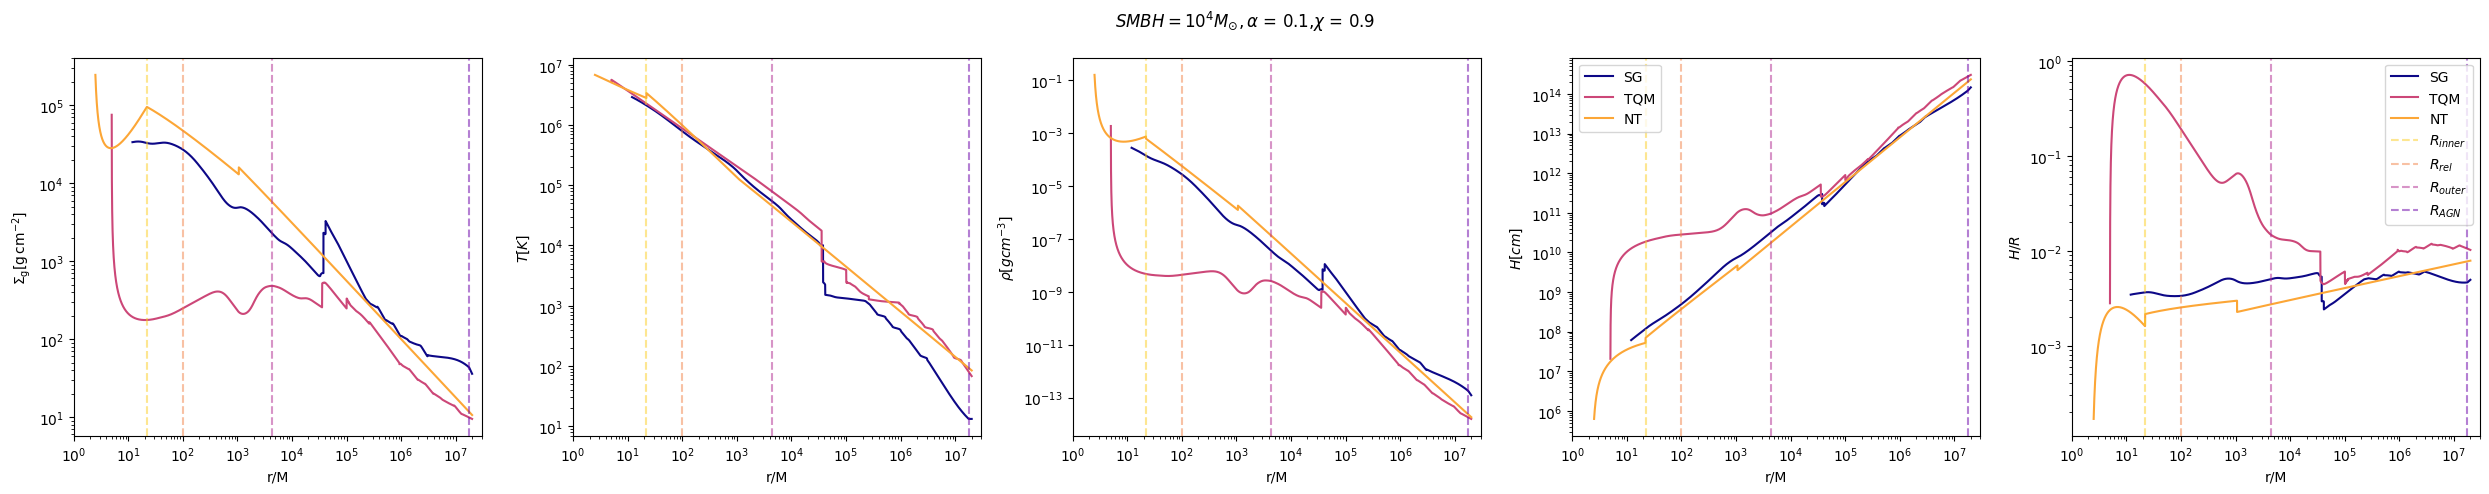

MBH=1e4 MSun, alpha=0.1, spin=0.99
1.454497938059672
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 4.183587e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9999, R = 9992404.87198584Rs ###
Mdisk = 16.

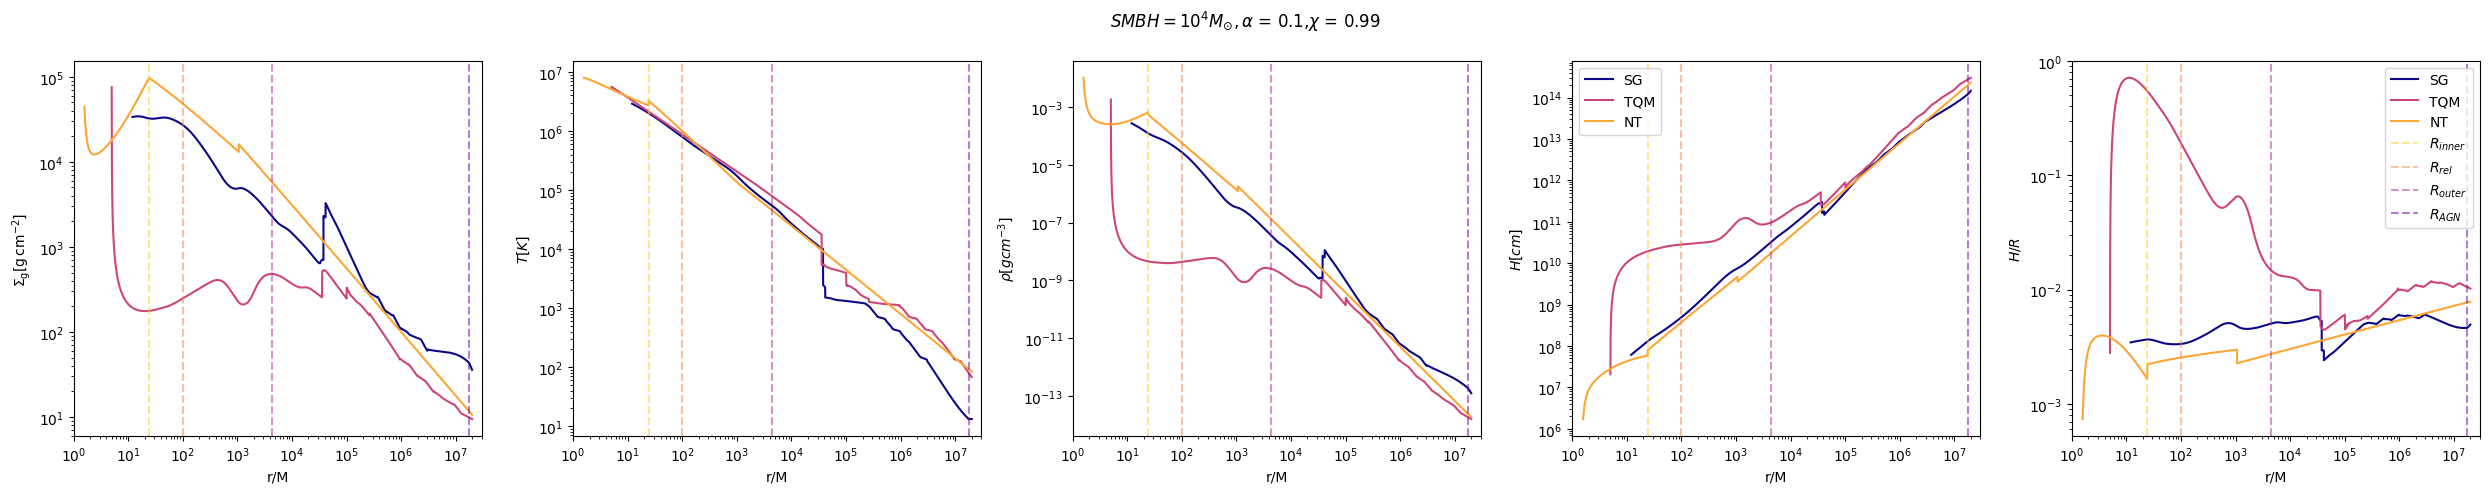

MBH=1e4 MSun, alpha=0.01, spin=0.9
2.3208830417618875
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 4.183587e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9999, R = 9992404.87198584Rs ###
Mdis

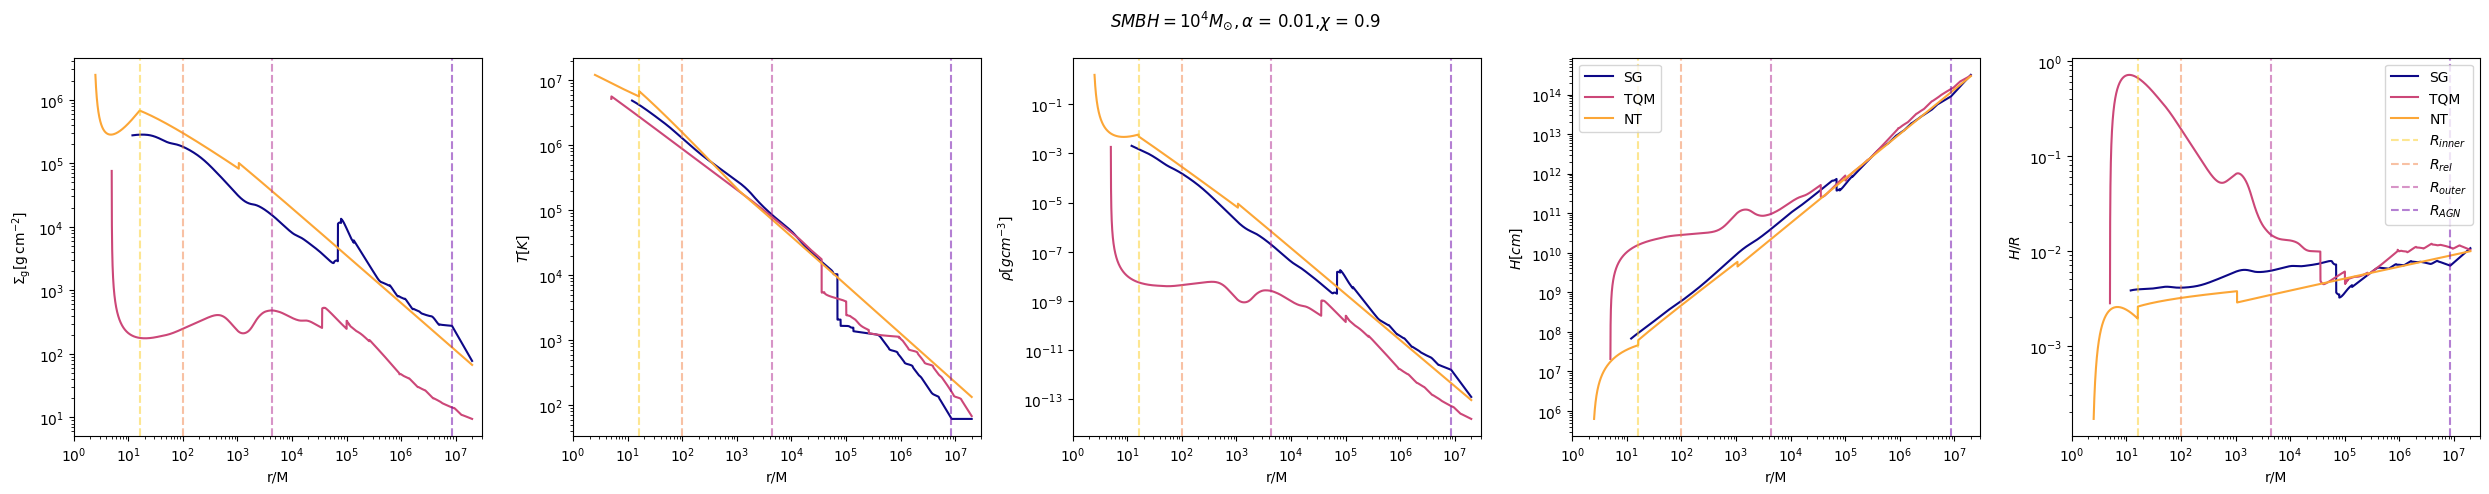

MBH=1e4 MSun, alpha=0.01, spin=0.99
1.454497938059672
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 4.183587e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9999, R = 9992404.87198584Rs ###
Mdis

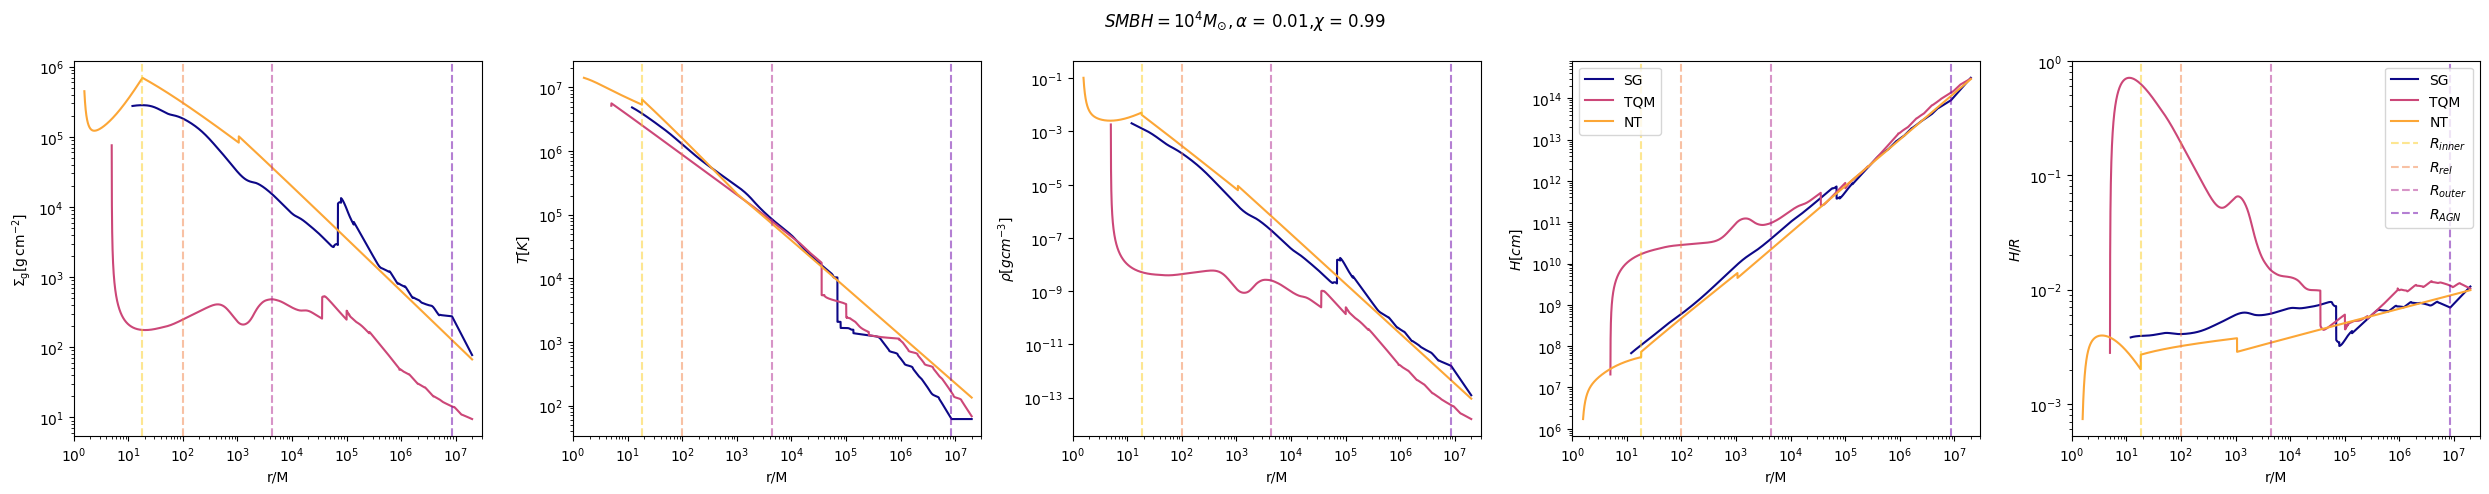

MBH=1e5 MSun, alpha=0.1, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761433622783 Msun
Mdisk/Mbh = 0.030937614336227832
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+05 MSun
Mdot_out = 1.239501e-02 MSun/yr
Rs = 9.570121e-09 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-02 pc
sigma = 3.686459e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9752, R = 6864345.596888853Rs ###
Mdisk =

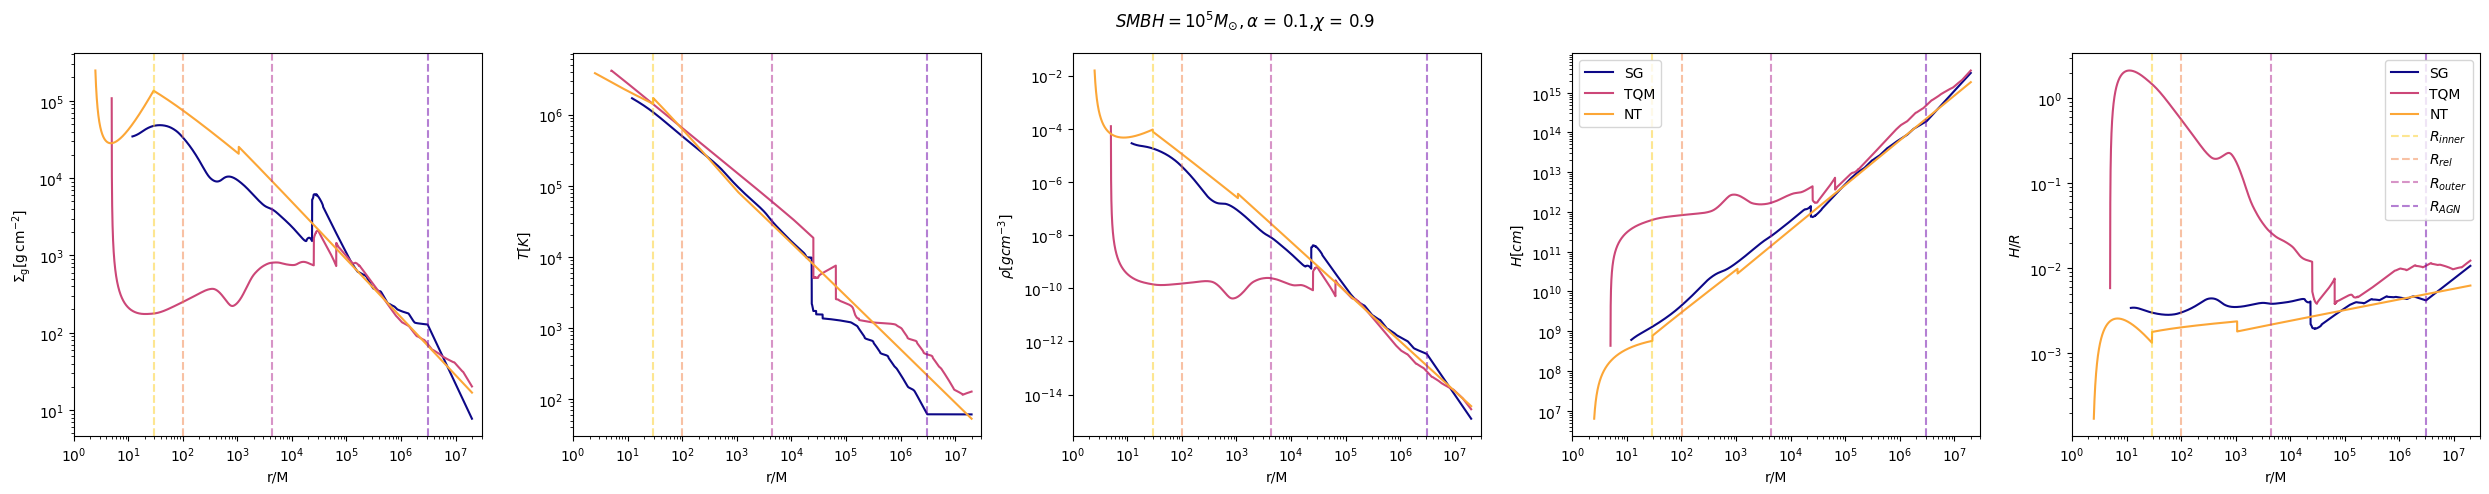

MBH=1e5 MSun, alpha=0.1, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761433622783 Msun
Mdisk/Mbh = 0.030937614336227832
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+05 MSun
Mdot_out = 1.239501e-02 MSun/yr
Rs = 9.570121e-09 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-02 pc
sigma = 3.686459e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9752, R = 6864345.596888853Rs ###
Mdisk

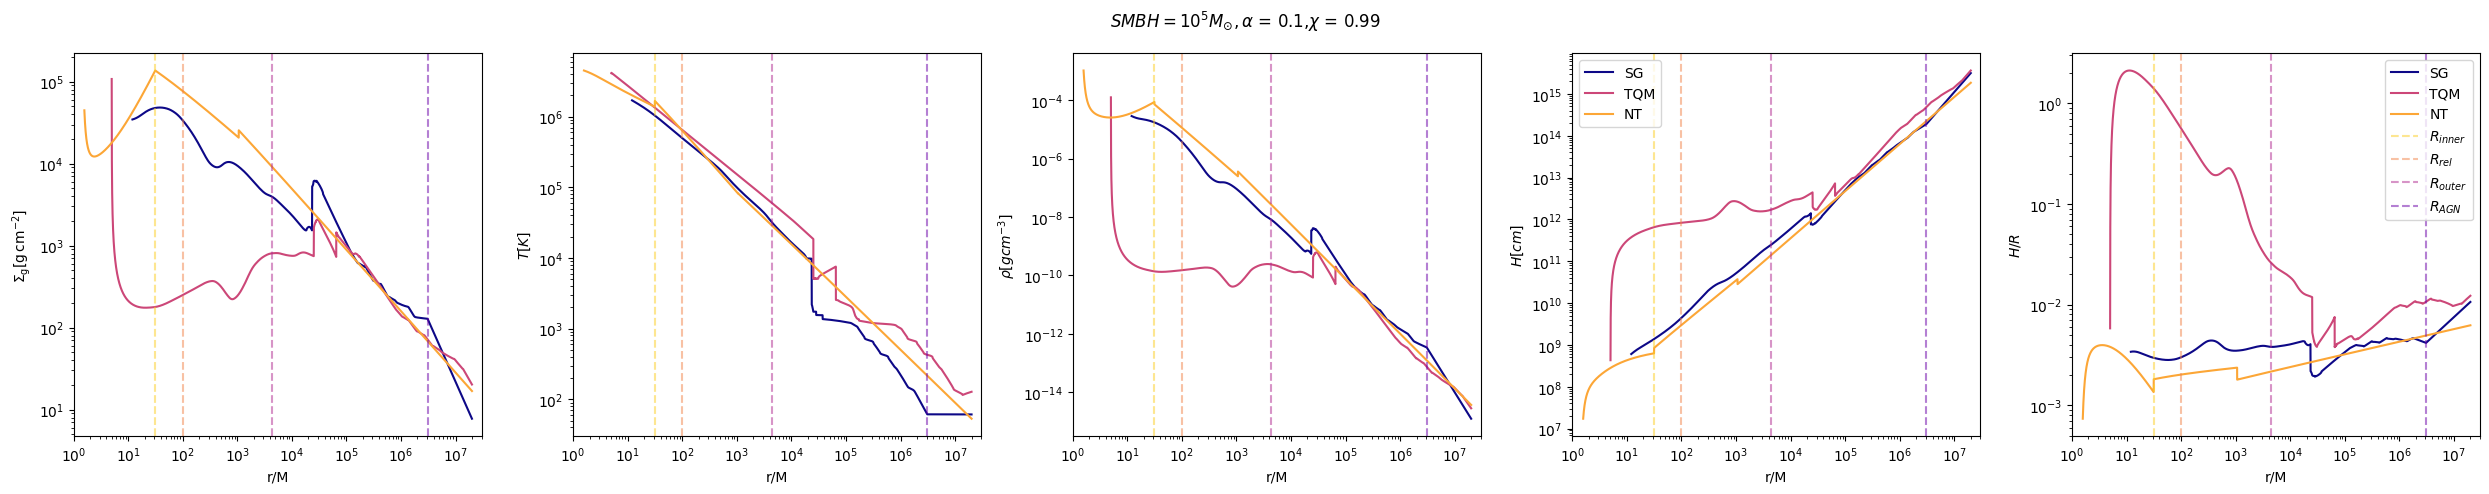

MBH=1e5 MSun, alpha=0.01, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982392929825 Msun
Mdisk/Mbh = 0.07742982392929826
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+05 MSun
Mdot_out = 1.239501e-02 MSun/yr
Rs = 9.570121e-09 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-02 pc
sigma = 3.686459e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9752, R = 6864345.596888853Rs ###
Mdisk 

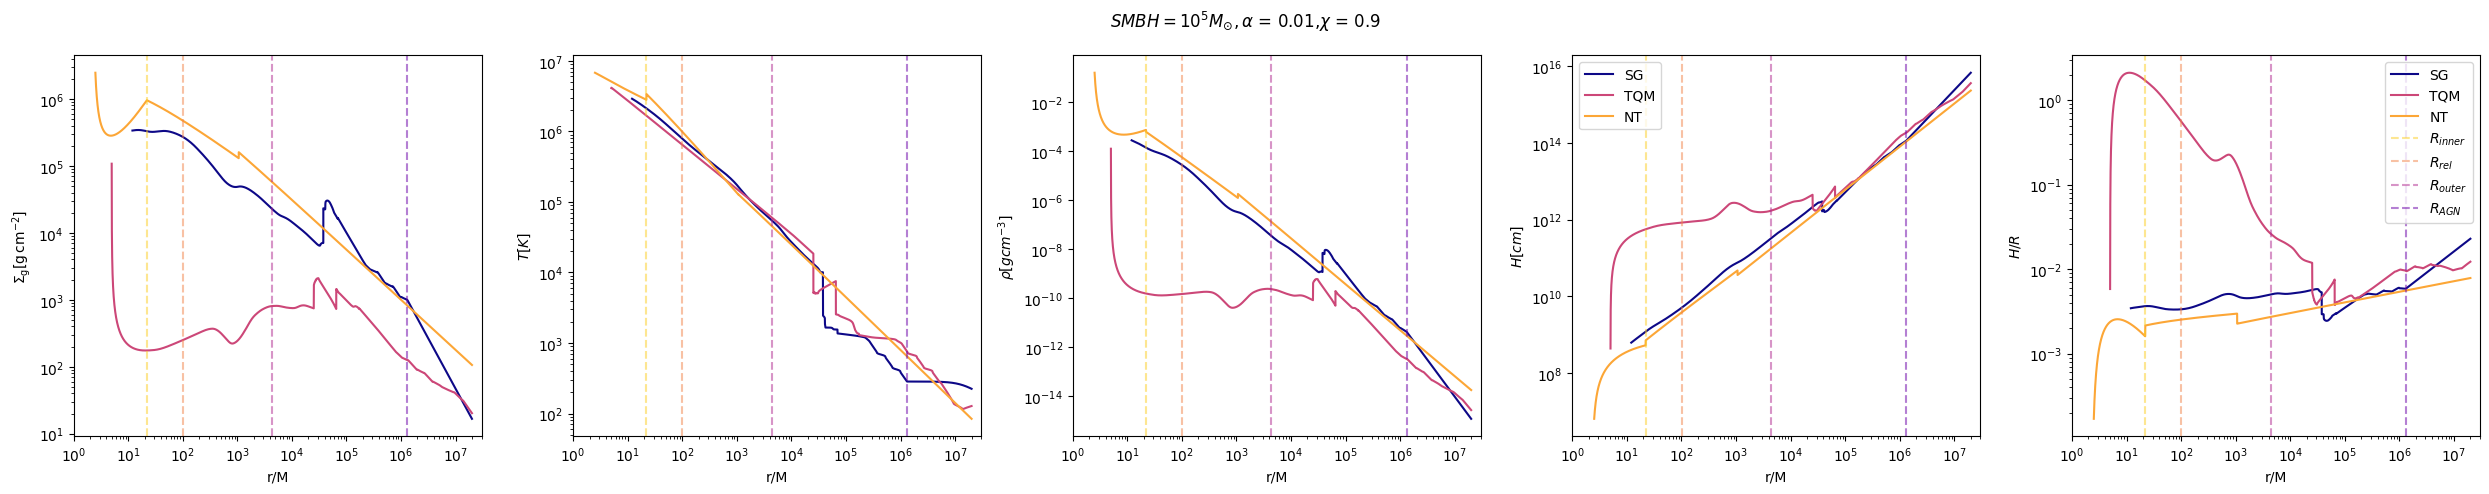

MBH=1e5 MSun, alpha=0.01, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982392929825 Msun
Mdisk/Mbh = 0.07742982392929826
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+05 MSun
Mdot_out = 1.239501e-02 MSun/yr
Rs = 9.570121e-09 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-02 pc
sigma = 3.686459e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9752, R = 6864345.596888853Rs ###
Mdis

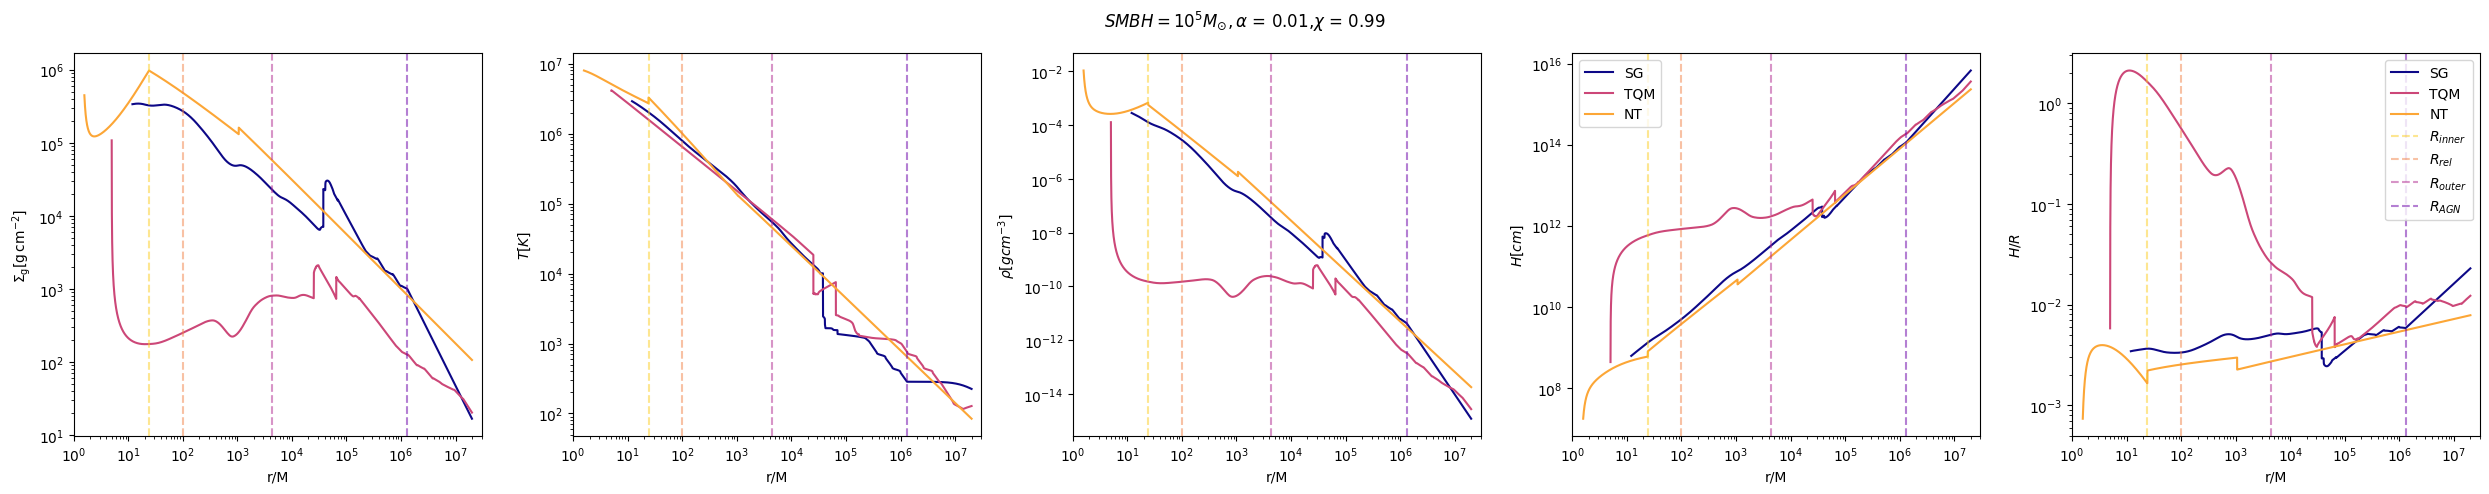

MBH=1e6 MSun, alpha=0.1, spin=0.9
2.3208830417618875
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73742415155 Msun
Mdisk/Mbh = 0.08318073742415157
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 3.672358e-01 MSun/yr
Rs = 9.570121e-08 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-01 pc
sigma = 6.345392e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 8082, R = 542069.687344145Rs ###
Mdisk = 

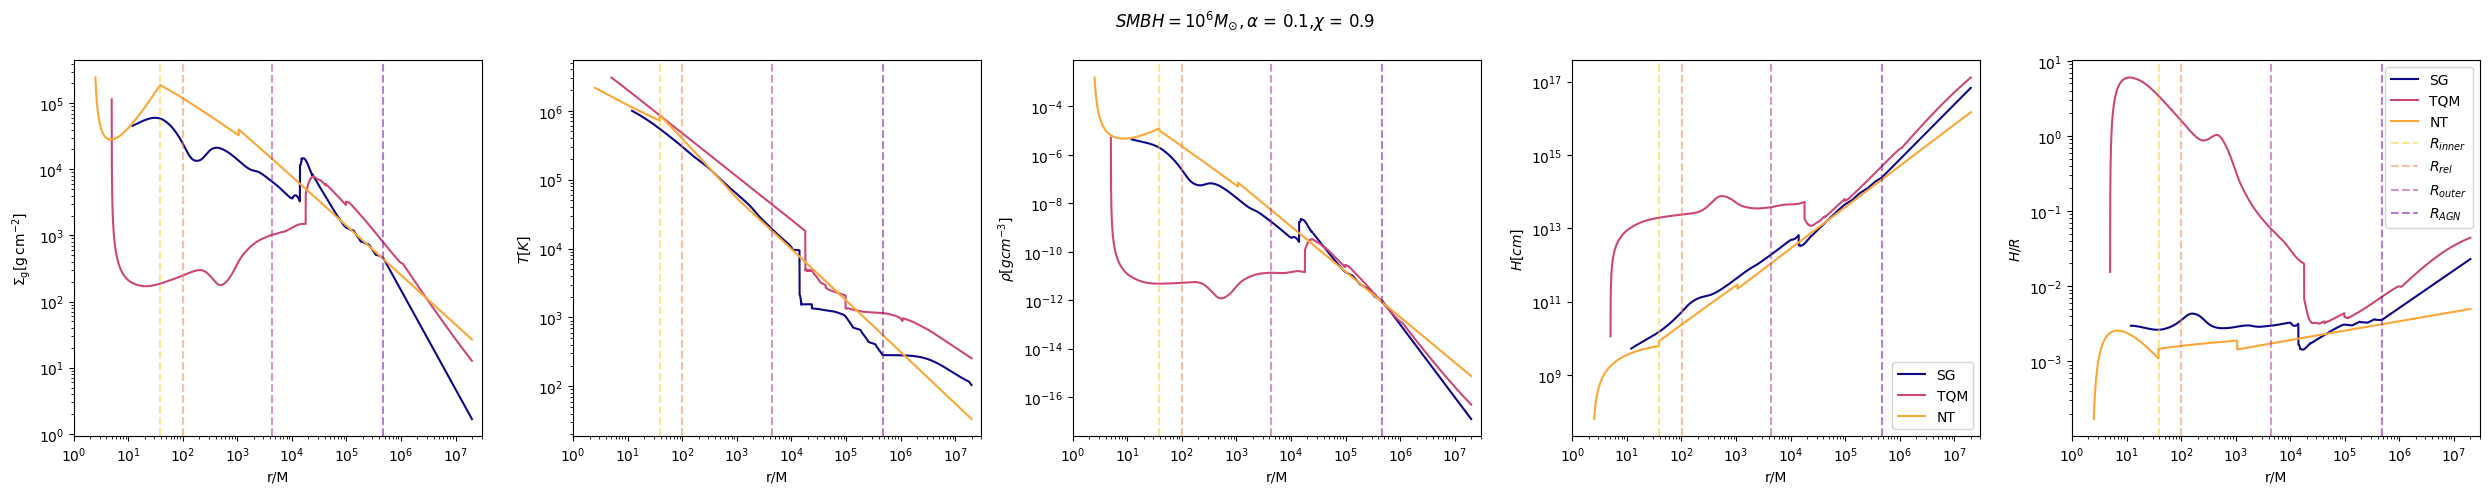

MBH=1e6 MSun, alpha=0.1, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73742415155 Msun
Mdisk/Mbh = 0.08318073742415157
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 3.672358e-01 MSun/yr
Rs = 9.570121e-08 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-01 pc
sigma = 6.345392e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 8082, R = 542069.687344145Rs ###
Mdisk =

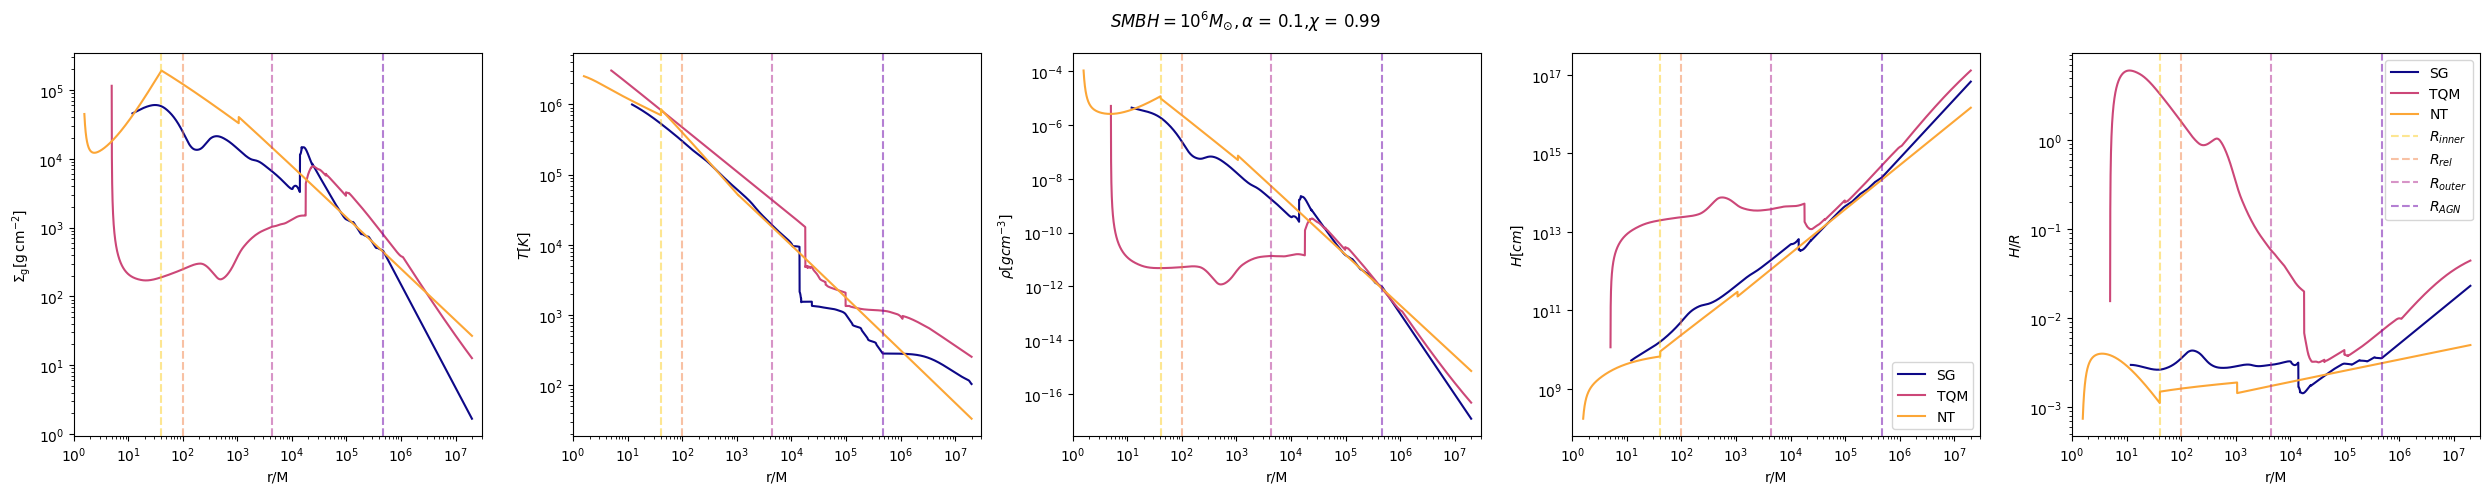

MBH=1e6 MSun, alpha=0.01, spin=0.9
2.3208830417618875
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.9646790749 Msun
Mdisk/Mbh = 0.1910869646790749
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 3.672358e-01 MSun/yr
Rs = 9.570121e-08 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-01 pc
sigma = 6.345392e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 8082, R = 542069.687344145Rs ###
Mdisk =

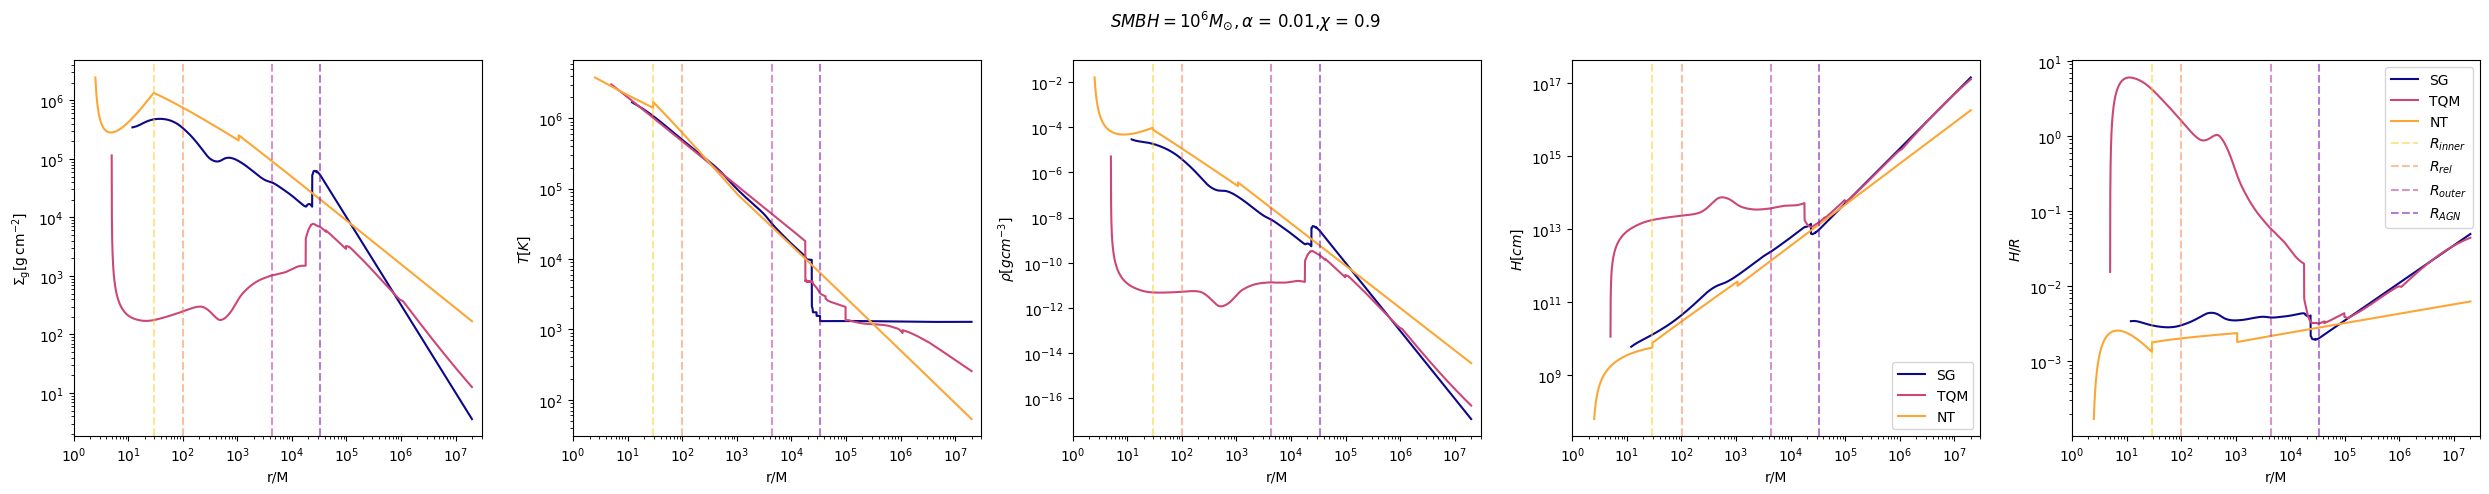

MBH=1e6 MSun, alpha=0.01, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.9646790749 Msun
Mdisk/Mbh = 0.1910869646790749
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 3.672358e-01 MSun/yr
Rs = 9.570121e-08 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-01 pc
sigma = 6.345392e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 8082, R = 542069.687344145Rs ###
Mdisk 

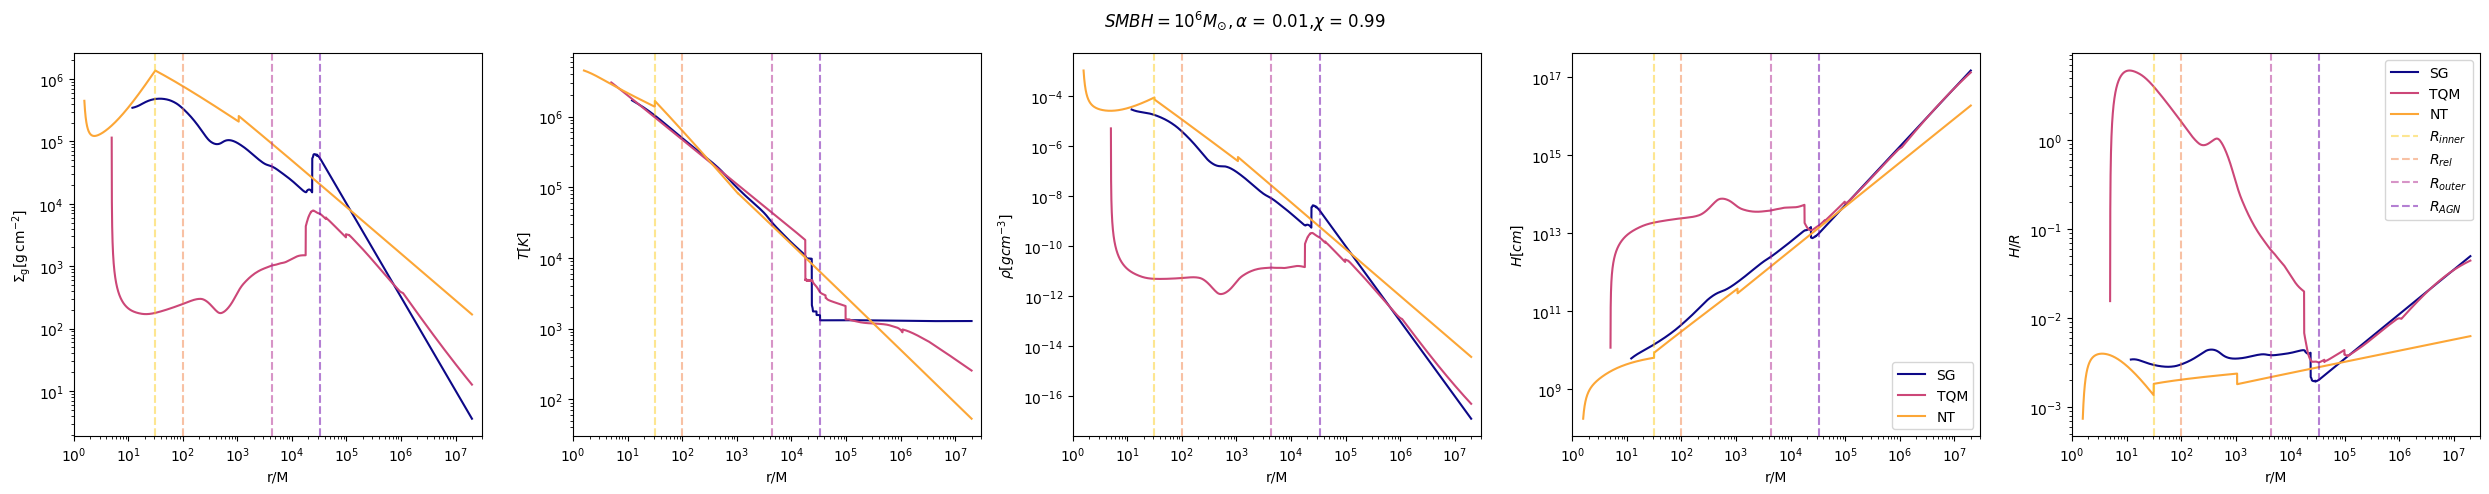

MBH=1e7 MSun, alpha=0.1, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.1640955193 Msun
Mdisk/Mbh = 0.19346011640955194
SG: 4.999999999999999 Rg, 4.999999999999999 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+07 MSun
Mdot_out = 1.088036e+01 MSun/yr
Rs = 9.570121e-07 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+00 pc
sigma = 1.092213e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6776, R = 744

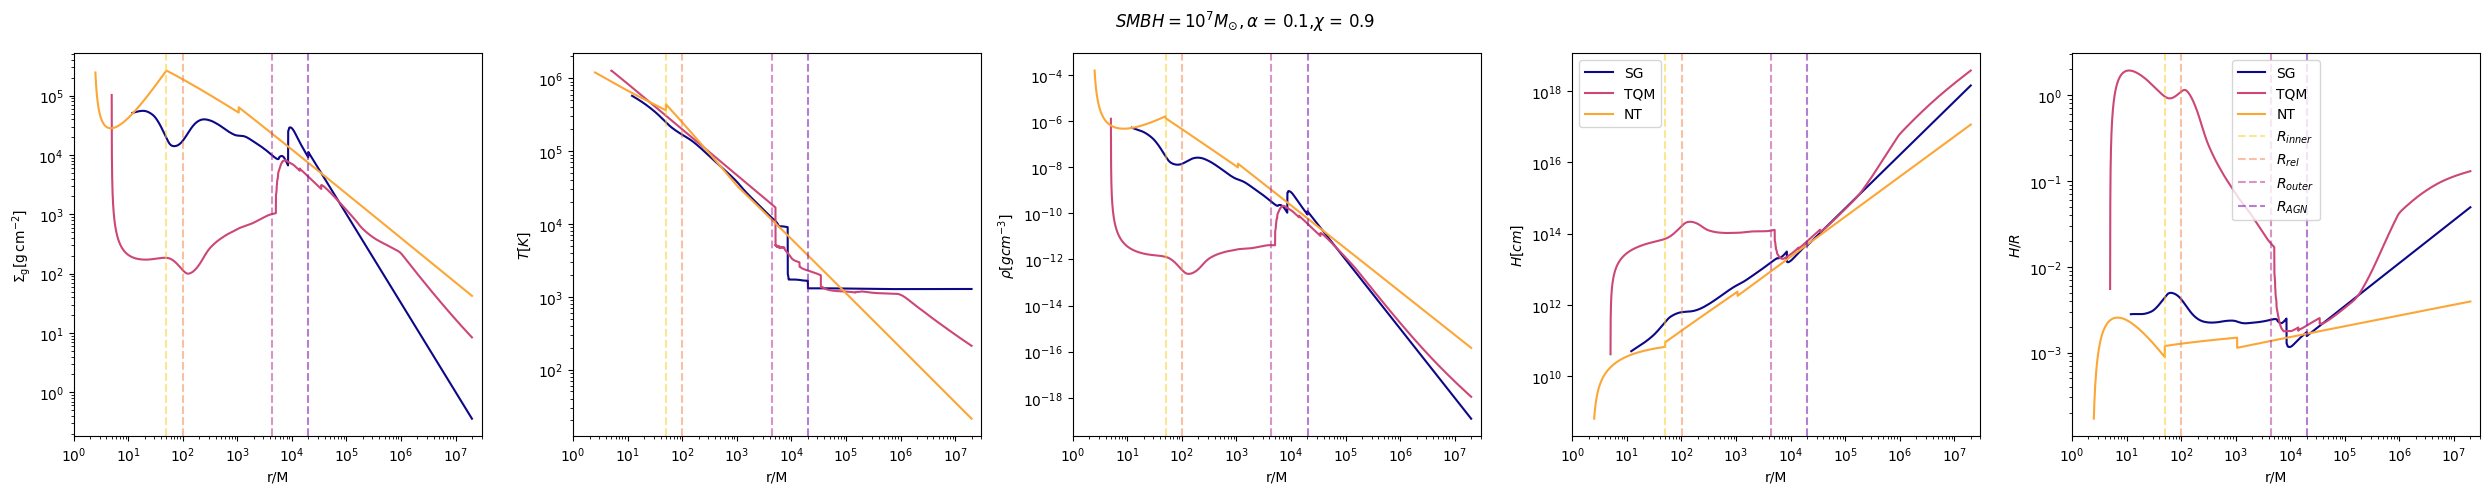

MBH=1e7 MSun, alpha=0.1, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.1640955193 Msun
Mdisk/Mbh = 0.19346011640955194
SG: 4.999999999999999 Rg, 4.999999999999999 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+07 MSun
Mdot_out = 1.088036e+01 MSun/yr
Rs = 9.570121e-07 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+00 pc
sigma = 1.092213e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6776, R = 7

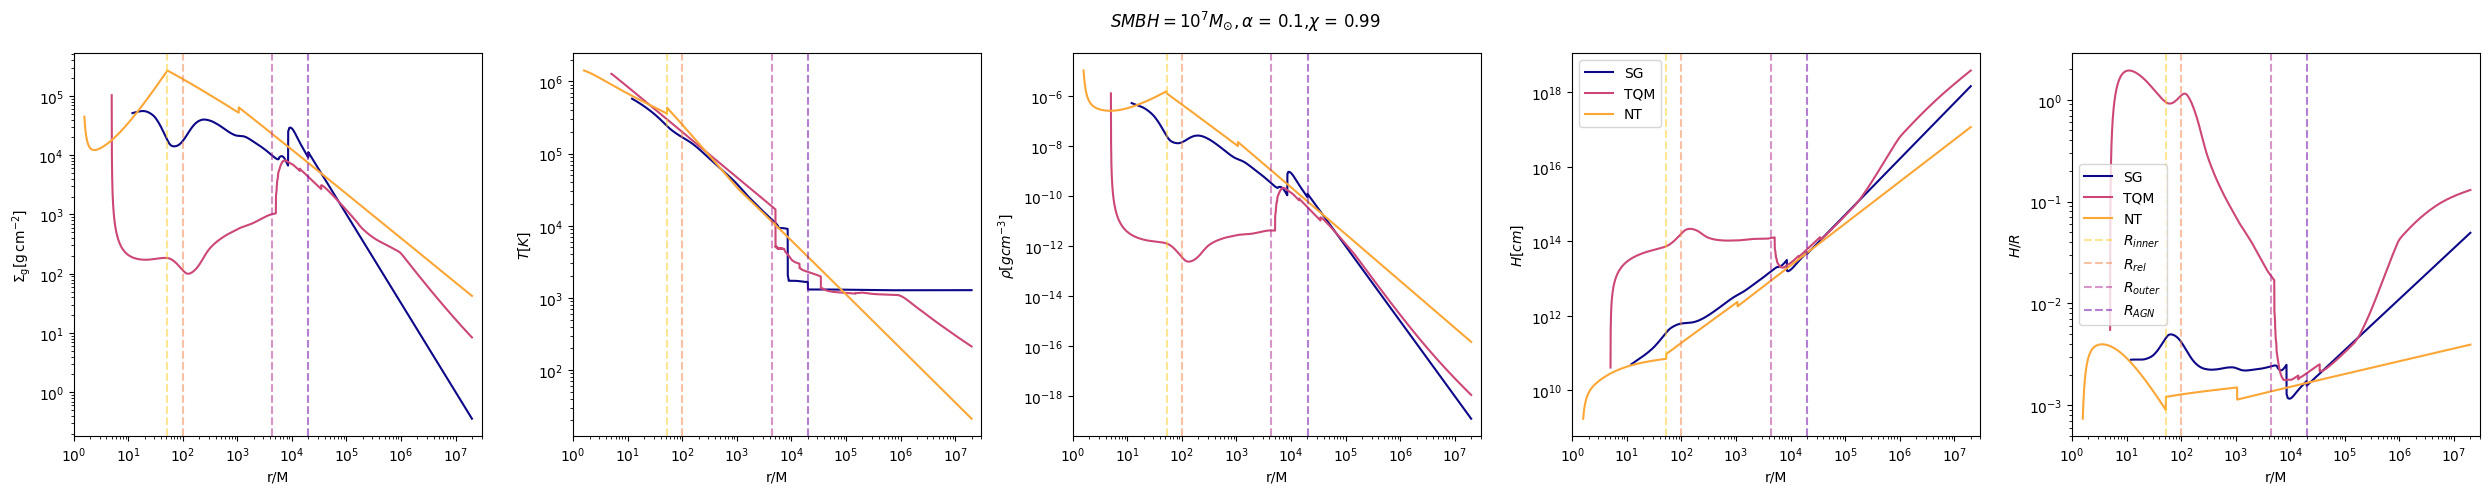

MBH=1e7 MSun, alpha=0.01, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610838735 Msun
Mdisk/Mbh = 0.41763893610838737
SG: 4.999999999999999 Rg, 4.999999999999999 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+07 MSun
Mdot_out = 1.088036e+01 MSun/yr
Rs = 9.570121e-07 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+00 pc
sigma = 1.092213e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6776, R = 7

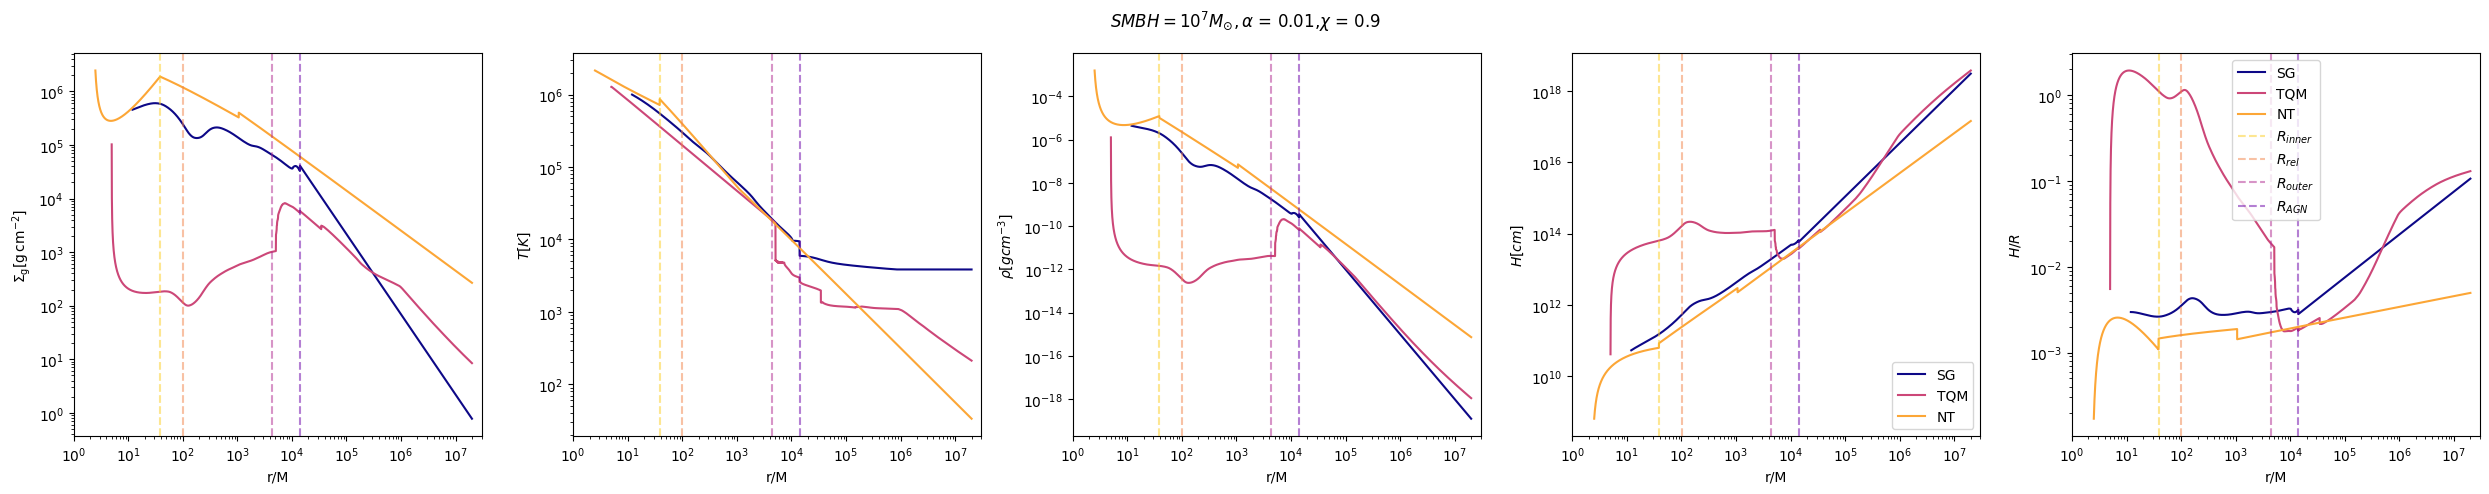

MBH=1e7 MSun, alpha=0.01, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610838735 Msun
Mdisk/Mbh = 0.41763893610838737
SG: 4.999999999999999 Rg, 4.999999999999999 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+07 MSun
Mdot_out = 1.088036e+01 MSun/yr
Rs = 9.570121e-07 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+00 pc
sigma = 1.092213e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6776, R =

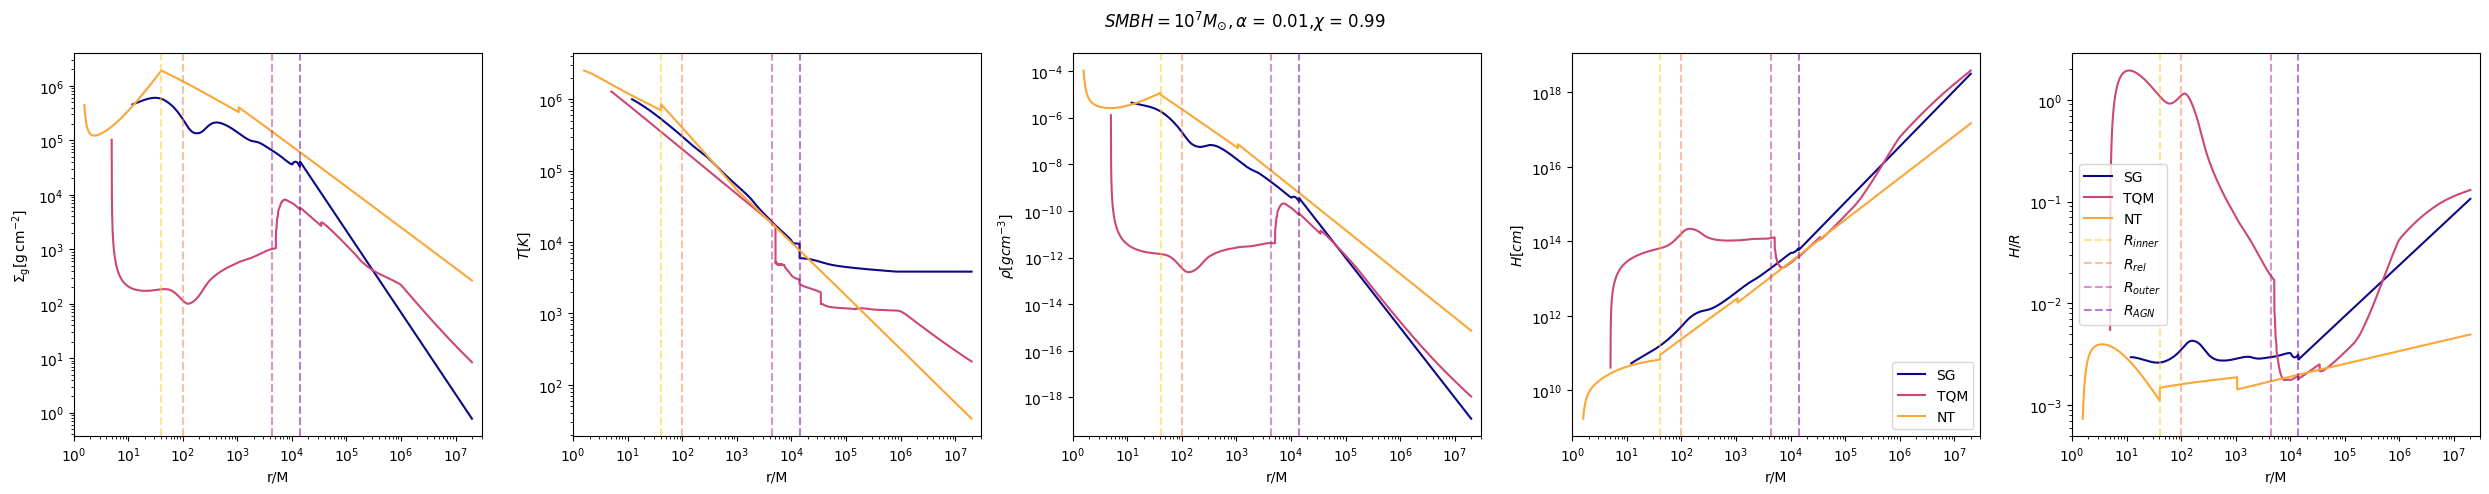

MBH=1e8 MSun, alpha=0.1, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4258 (R=2.68e+03 Rs)
Beginning star formation at index 4258
Mdisk = 42089684.933762535 Msun
Mdisk/Mbh = 0.42089684933762533
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+08 MSun
Mdot_out = 3.223601e+02 MSun/yr
Rs = 9.570121e-06 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+01 pc
sigma = 1.879994e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 5929, R = 20541.474086091846Rs ###
Mdisk 

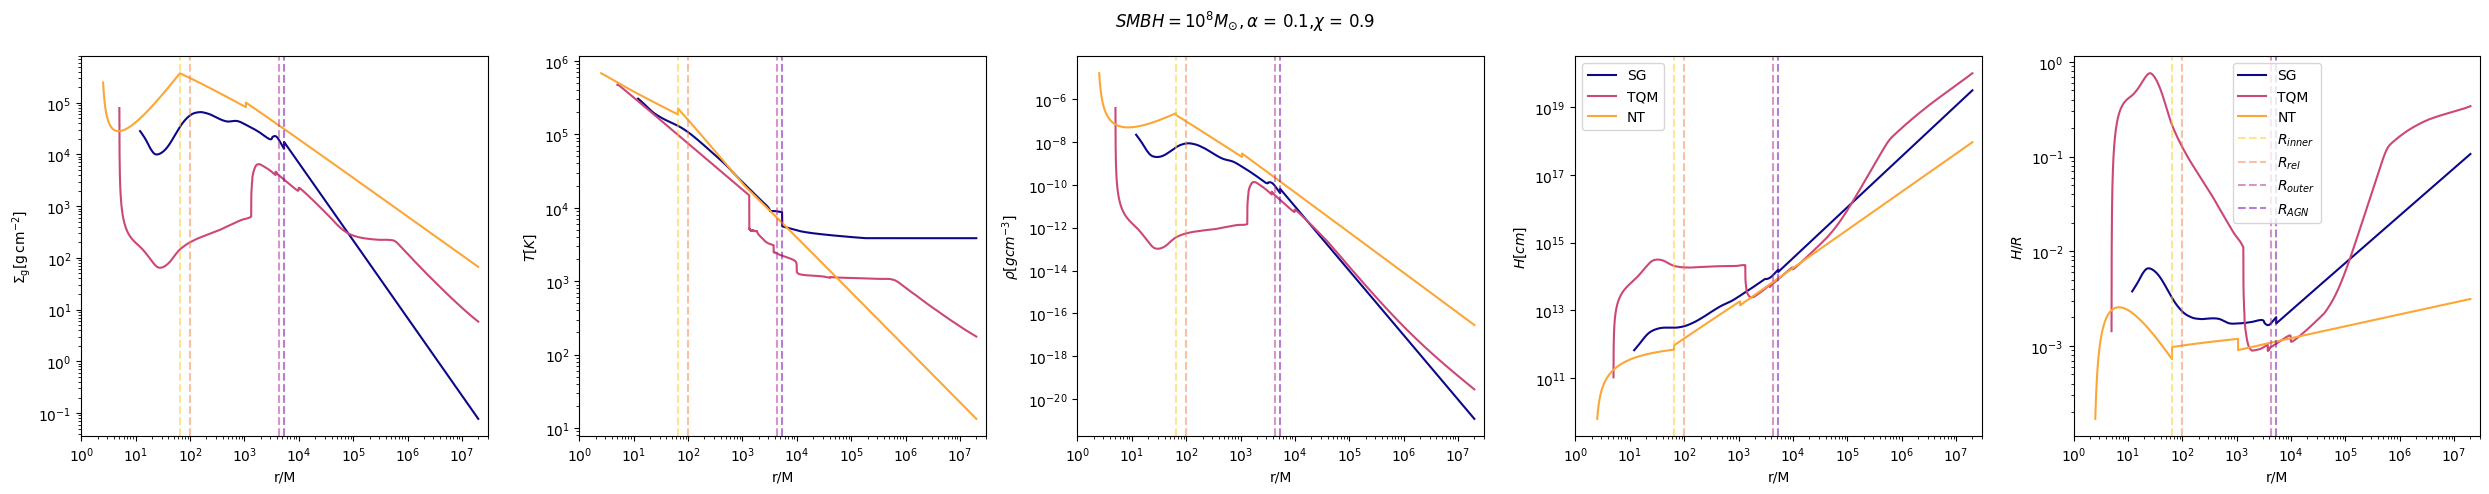

MBH=1e8 MSun, alpha=0.1, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4258 (R=2.68e+03 Rs)
Beginning star formation at index 4258
Mdisk = 42089684.933762535 Msun
Mdisk/Mbh = 0.42089684933762533
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+08 MSun
Mdot_out = 3.223601e+02 MSun/yr
Rs = 9.570121e-06 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+01 pc
sigma = 1.879994e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 5929, R = 20541.474086091846Rs ###
Mdis

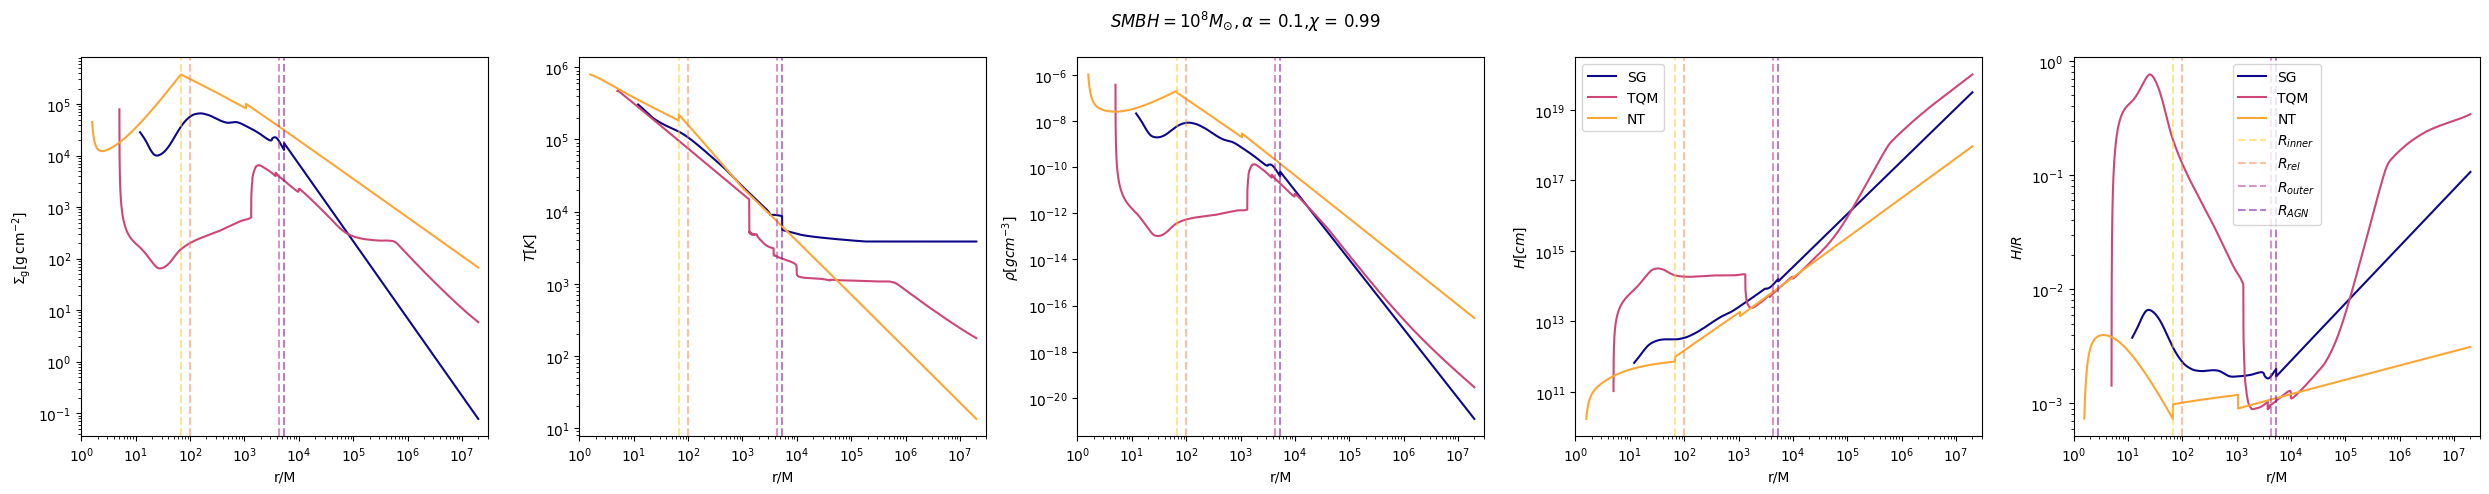

MBH=1e8 MSun, alpha=0.01, spin=0.9
2.320883041761887
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3550 (R=9.71e+02 Rs)
Beginning star formation at index 3550
Mdisk = 91092263.30802898 Msun
Mdisk/Mbh = 0.9109226330802896
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+08 MSun
Mdot_out = 3.223601e+02 MSun/yr
Rs = 9.570121e-06 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+01 pc
sigma = 1.879994e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 5929, R = 20541.474086091846Rs ###
Mdisk 

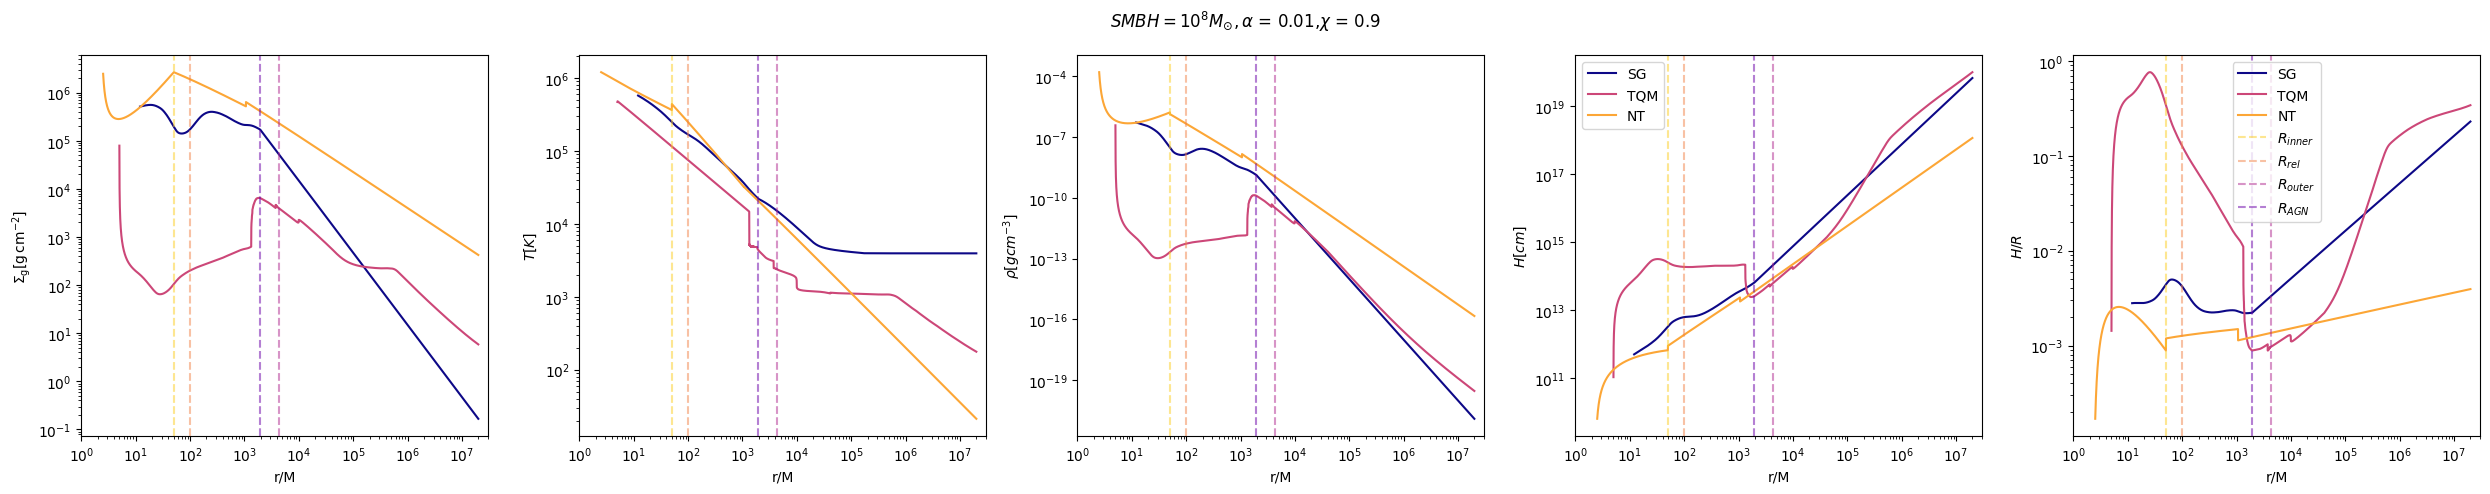

MBH=1e8 MSun, alpha=0.01, spin=0.99
1.4544979380596716
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3550 (R=9.71e+02 Rs)
Beginning star formation at index 3550
Mdisk = 91092263.30802898 Msun
Mdisk/Mbh = 0.9109226330802896
SG: 5.0 Rg, 5.0 Rg, 12.008601961967756 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+08 MSun
Mdot_out = 3.223601e+02 MSun/yr
Rs = 9.570121e-06 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+01 pc
sigma = 1.879994e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 5929, R = 20541.474086091846Rs ###
Mdis

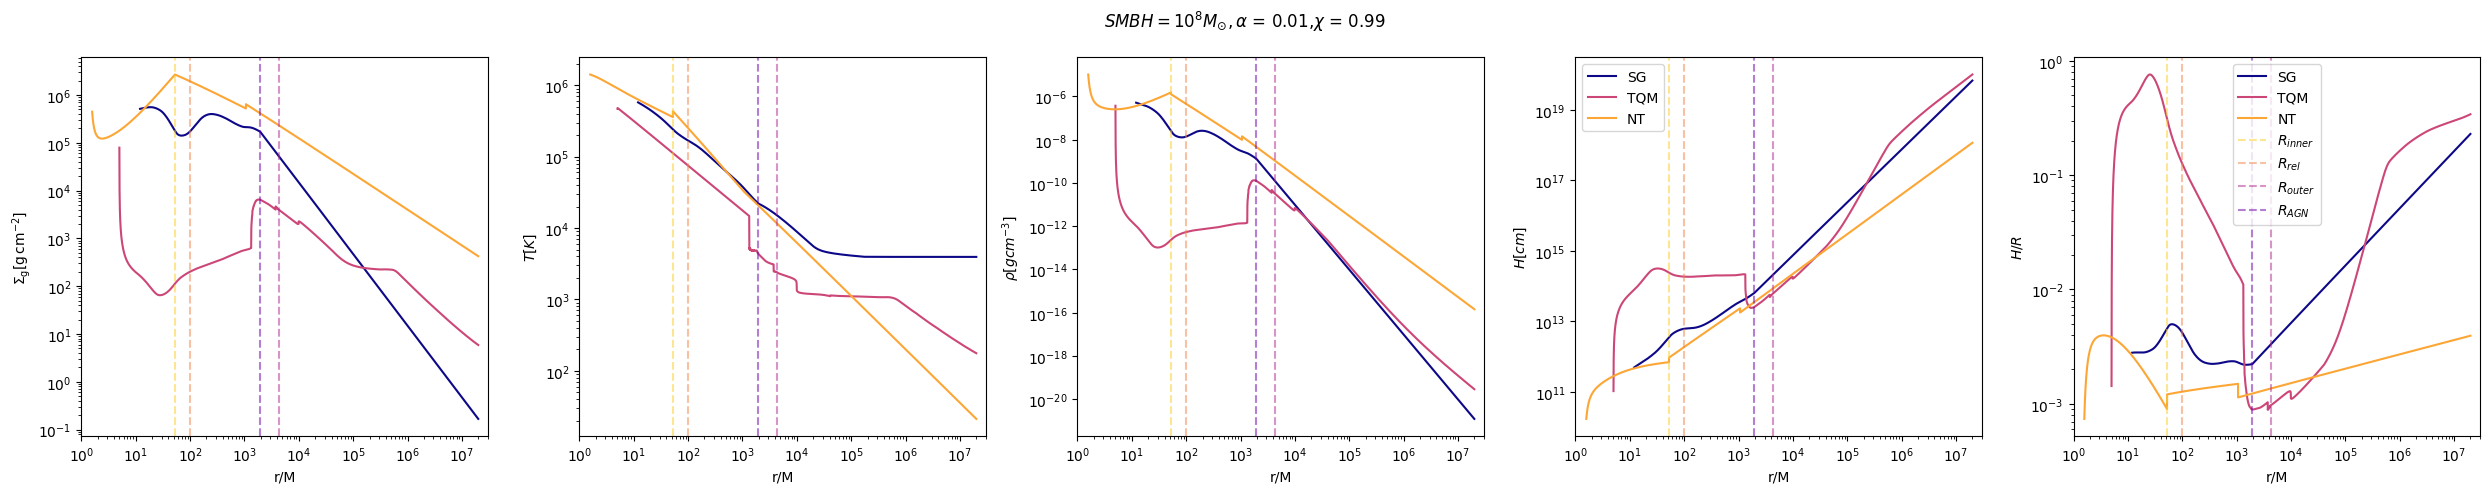

In [64]:
# MBH_powers= 4.5, 5.5, 6.5, 7.5
MBH_powers= 4,5,6,7,8

spins=0.9, 0.99
alphas=0.1, 0.01

mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps
# mdot=le/eps

# X=0.7
# b=0
# Opacity='combined'
# kappa=0.2 * (1+X) * 0.1

steps=int(1e4)

for power in MBH_powers:
    for alpha in alphas:
        for spin in spins:
            print(f'MBH=1e{power} MSun, alpha={alpha}, spin={spin}')
            r_isco=jscript.R_isco_function(10**power, spin)
            M=10**power * ct.G /(ct.c*ct.c)
            R_G=M
            print(r_isco/R_G)
            path=f'EMRIs_Jupiter_2/NT_vs_SG_vs_TQM_profiles/logMBH{power}/alpha{alpha}/mdot{mdot}/spin{spin}/'
            NTvsSG_disc_solver_smooth(power, spin, alpha, mdot, eps=eps, le=le, steps=int(1e4), path=path, printing=True, plotting=True, save_to_file=True)

In [3]:
import Thompson_edited as edit

In [6]:
MBH=10**5 * ct.MSun
# spin=0.9
# Rmin=jscript.R_isco_function(MBH, spin)
# R_G=MBH * ct.G /(ct.c*ct.c)
# Rout=1e7*R_G
# sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
# Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

R_G=MBH * ct.G /(ct.c*ct.c)
Rout=1e7*R_G
sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2
diskTQM = pagn.ThompsonAGN(Mbh=MBH, Mdot_out=Mdot_out)

# diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
diskTQM.solve_disk()


sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+05 MSun
Mdot_out = 6.197505e-03 MSun/yr
Rs = 9.570121e-09 pc
Rin = 3.000000e+00 Rs
Rout = 2.089838e+10 Rs = 2.000000e+02 pc
sigma = 3.686459e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6658, R = 10741805.754164297Rs ###
Mdisk = 5659182.708165329 Msun
Mdisk/Mbh = 56.59182708165329


4.0
1.3180560049110122e+19
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 2.091793e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 1.160442e+00 Rs
Rout = 5.000000e+06 Rs = 4.785061e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
4.004004004004004
1.3360618066128722e+19
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.009262e+04 MSun
Mdot_out = 2.120369e-04 MSun/yr
Rs = 9.658761e-10 pc
Rin = 1.149792e+00 Rs
Rout = 5.000000e+06 Rs = 4.829381e-03 pc
sigma = 2.146370e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
4.008008008008008
1.3543135833671676e+19
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.018610e+04 MSun
Mdot_out = 2.149335e-04 MSun/yr
Rs = 9.748223e-10 pc
Rin = 1.139240e+00 Rs
Rout = 5.000000e+06 Rs = 4.87411

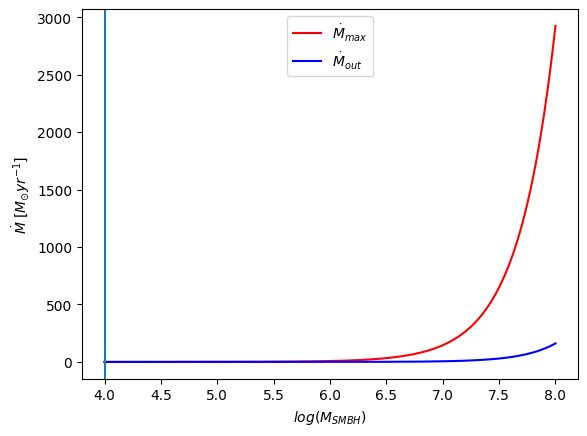

In [8]:
Mdotmaxs=[]
Mdotouts=[]
MBHs=[]

powers=np.linspace(4,8, 1000)

flag=0

for power in powers:
    print(power)
    MBH=10**power * ct.MSun
    MBHs.append(MBH)

    R_G=MBH * ct.G /(ct.c*ct.c)

    Rout=1e7*R_G

    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)

    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    print(Mdot_out)

    diskTQM = edit.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
    diskTQM.solve_disk()
    Mdotmax= diskTQM.Mdotmax * (ct.yr / ct.MSun)
    Mdotout= diskTQM.Mdot_out * (ct.yr / ct.MSun)
    Mdotmaxs.append(Mdotmax)
    Mdotouts.append(Mdotout)
    if Mdotmax>Mdotout and flag==0:
        power_crit=power
        flag+=1

print(f'Mdot max exceeds Mdot out at SMBH = 1e{power_crit} MSun')

plt.plot(powers, Mdotmaxs, color='r', label='$\dot{M}_{max}$')
plt.plot(powers, Mdotouts, color='b', label='$\dot{M}_{out}$')
plt.axvline(x=power_crit)
plt.xlabel('$log(M_{SMBH})$')
plt.ylabel('$\dot{M}~[M_{\odot}yr^{-1}]$')
plt.title("")
plt.legend()
plt.show()
# diskTQM.solve_disk(N=1e4)

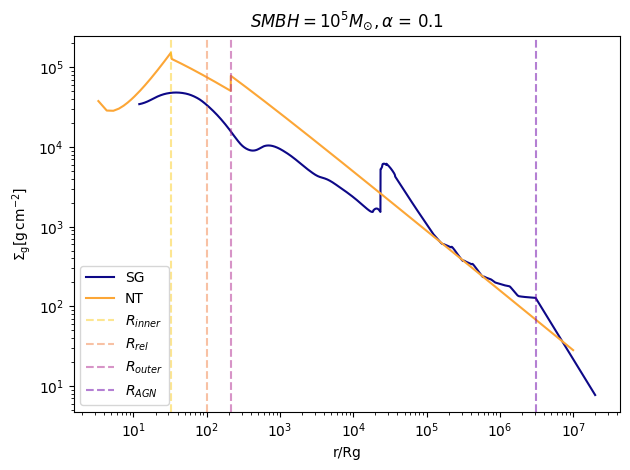

In [18]:
colour='plasma'
cmap = plt.colormaps[colour]

plt.plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
plt.ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, sigmas_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, sigmas_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")


plt.legend()

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')

plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_SD_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()

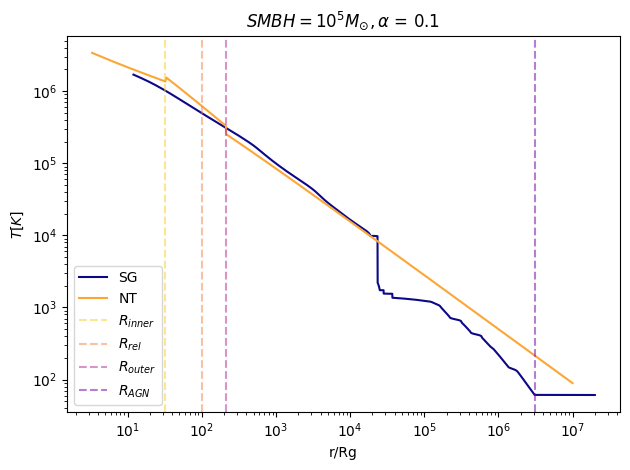

In [19]:

plt.plot(disk.R/R_G, disk.T, color=cmap(0.0), label = r"SG")
plt.ylabel(r'$T [K] $')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, Ts_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, Ts_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_T_profiles_logMBH{MBH_power}_alpha{alpha}_2.pdf')
plt.show()

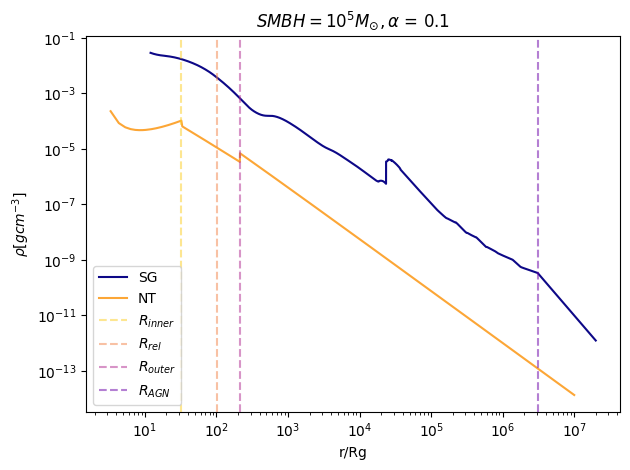

In [20]:

plt.plot(disk.R/R_G, disk.rho, color=cmap(0.0), label = r"SG")
plt.ylabel(r'$\rho [gcm^{-3}] $')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, Ts_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, Ts_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_rho_profiles_logMBH{MBH_power}_alpha{alpha}_2.pdf')
plt.show()

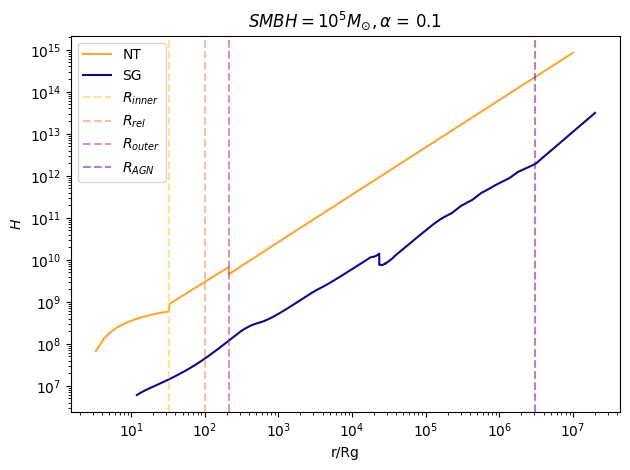

In [21]:

plt.ylabel(r'$H$')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

plt.plot(disk.R/R_G, disk.h, '-', color=cmap(0.0), label = r"SG")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_H_profiles_logMBH{MBH_power}_alpha{alpha}.pdf')
plt.show()

In [18]:
disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le= le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 1.298344e+00 MSun/yr
le = 0.5
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3408 (R=7.92e+02 Rs)
Beginning star formation at index 3408
Mdisk = 335459537.4383986 Msun
Mdisk/Mbh = 3.354595374383986


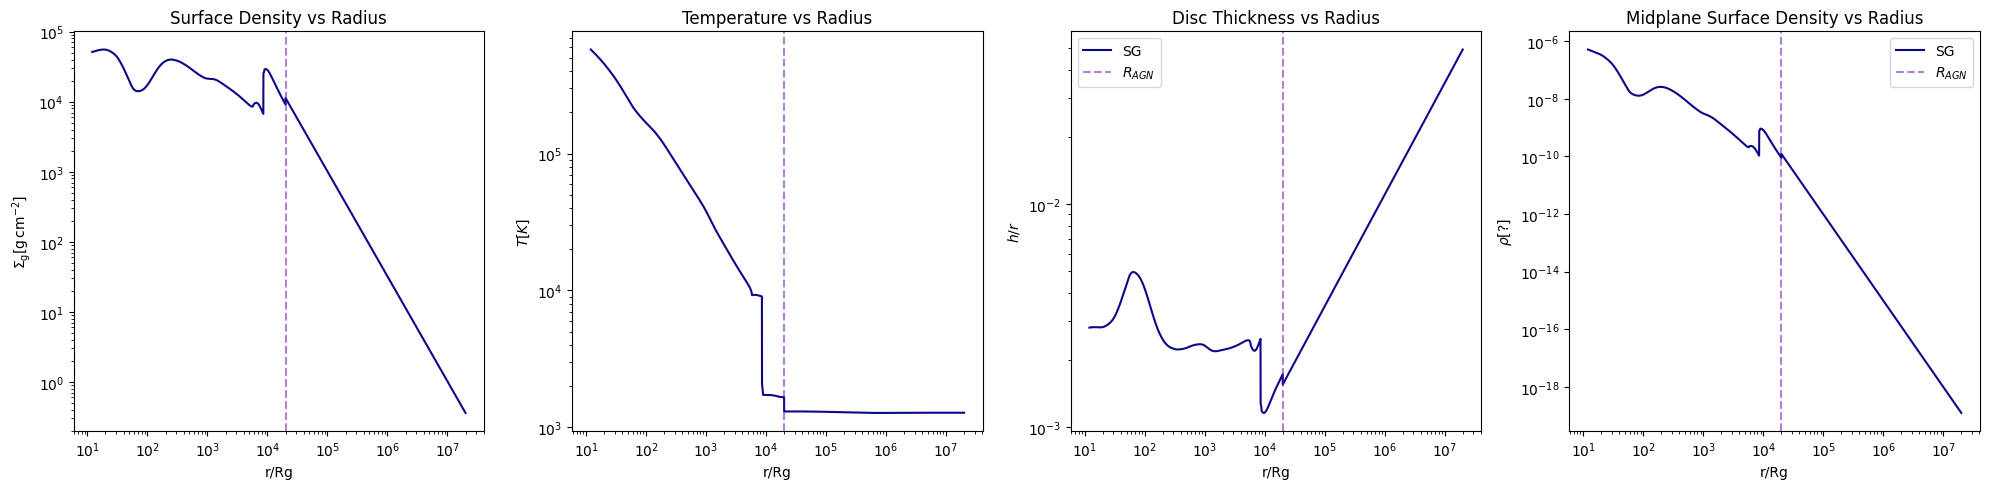

In [25]:
colour='plasma'
cmap = plt.colormaps[colour]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

i=0
axs[i].plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(5, 1e6)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Surface Density vs Radius')

i=1
axs[i].plot(disk.R/R_G, disk.T, color=cmap(0.0), label = r"SG")
axs[i].set_ylabel(r'$T [K] $')
axs[i].set_xlabel("r/Rg")

axs[i].set_xscale('log')
axs[i].set_yscale('log')

# axs[i].set_xlim(5, 1e7)
# axs[i].set_ylim(1e1, 3e7)
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Temperature vs Radius')

i=2

axs[i].plot(disk.R/R_G, disk.h/disk.R, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$h/r$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Disc Thickness vs Radius')
axs[i].legend()

i=3

axs[i].plot(disk.R/R_G, disk.rho/1e3, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\rho [?]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Midplane Surface Density vs Radius')
axs[i].legend()


plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/SG_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()

In [17]:
def BHL_accretion(args, obj, MBH, mbh, Mdot, gamma):
    drhodr=jscript.drhodR(obj)
    
    h=obj.h
    cs=obj.cs
    r=obj.R
    rho=obj.rho
    sigma= 2*h*rho

    E=MBH/(2*r)
    J=MBH * np.sqrt(1/(2*E))

    dJdr=jscript.dJdR(obj, J)

    deltav_psi=h*cs*(3-drhodr)/2
    deltav_dr=3/2 * (mbh/(3*MBH))**(1/3) * (1/h) * cs
    deltav_r=np.abs(-Mdot/(2 * np.pi * r * sigma) - gamma/dJdr)
    vrel=((deltav_psi + deltav_dr)**2 + deltav_r**2)**(1/2)
    mdot_BHL= (4 * np.pi * rho * mbh * mbh) / (vrel**2 + cs**2)**(3/2)
    return mdot_BHL

In [4]:
Mbh=10**4 * ct.MSun
alpha=0.1
mdot=0.1
eps=0.1
mbh=10 * ct.MSun

le=eps*mdot

M=Mbh * ct.G /(ct.c*ct.c)

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot=le * Ledd / eps

disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

rho=disk.rho
cs=disk.cs
R=disk.R
h=disk.h
sigma=2*h*rho

gamma=jscript.drhodR(disk)

deltav_phi=(3-gamma)/2 * (h / R) * cs
deltav_dr=3/2 * (mbh/(3*Mbh))**(1/3) * (1/h) * cs

vgas=-Mdot/(2 * np.pi * R * sigma)
vstar=-1.3e-6 * (mbh/(10*ct.MSun))/(Mbh/(1e5*ct.MSun)) * (R/10*M)**(-3)
deltav_r=np.abs(vgas-vstar)

vrel_sqr=(deltav_phi + deltav_dr)**2 + deltav_r**2

mdot_BHL=(4 * np.pi * rho * mbh * mbh) / (vrel_sqr + cs**2)**(3/2)

print(mdot_BHL)

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
[22790842.36859039 22868597.11898778 22946621.50935815 ...
 57531898.24894496 57162212.17189477 56794901.5936494 ]


In [10]:
from NT_disk_Eqns_V1 import A_fn, B_fn, C_fn, D_fn, E_fn, Q_fn

In [38]:
def disc_solver(MBH_power, spin, alpha, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    print(f'SG: {Rmin/R_G} Rg, {disk.Rmin/R_G} Rg, {disk.R[0]/R_G} Rg')

    Rout=Rmax
    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rout=Rout, Rin=Rmin, Mdot_out=Mdot_out)
    diskTQM.solve_disk()

    print(f'TQM: {Rmin/R_G} Rg, {diskTQM.Rin/R_G} Rg, {diskTQM.R[0]/R_G} Rg')

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    As=[]
    Bs=[]
    Cs=[]
    Ds=[]
    Es=[]
    Qs=[]

    coefficient=[]

    Rs=[]

    k=50
    if printing==True:
        print(R_oa/R_agn)
        print(f'Initial Radius = {R[k]/R_G} Rg, R_isco = {r_isco/R_G} Rg')

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)
        r_im=jscript.r_in_mid(y, MBH, spin, mdot, alpha)
        r_mo=jscript.r_mid_outer(y, MBH, spin, mdot)

        A=A_fn(y, spin)
        B=B_fn(y, spin)
        C=C_fn(y, spin)
        D=D_fn(y, spin)
        E=E_fn(y, spin)
        Q=Q_fn(y, MBH, spin)

        coefficient.append(A**(2/3) * D**(-1/3) * Q**(2/3))

        As.append(A)
        Bs.append(B)
        Cs.append(C)
        Ds.append(D)
        Es.append(E)
        Qs.append(Q)

        Rs.append(rstar)
        
    plt.plot(Rs, As, label='A')
    # plt.plot(Rs, Bs, label='B')
    # plt.plot(Rs, Cs, label='C')
    plt.plot(Rs, Ds, label='D')
    # plt.plot(Rs, Es, label='E')
    plt.plot(Rs, Qs, label="Q")

    plt.plot(Rs, coefficient, label='coeff')

    plt.xlabel('R/M')

    plt.xscale('log')
    plt.yscale('log')

    plt.legend()

    plt.tight_layout()
    plt.show()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
SG: 5.0 Rg, 5.0 Rg, 12.008601961967758 Rg
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+04 MSun
Mdot_out = 4.183587e-04 MSun/yr
Rs = 9.570121e-10 pc
Rin = 2.500000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-03 pc
sigma = 2.141708e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 9999, R = 9992404.87198584Rs ###
Mdisk = 16.999328663809198 Msun
Mdisk/Mbh = 0.001699932866380919

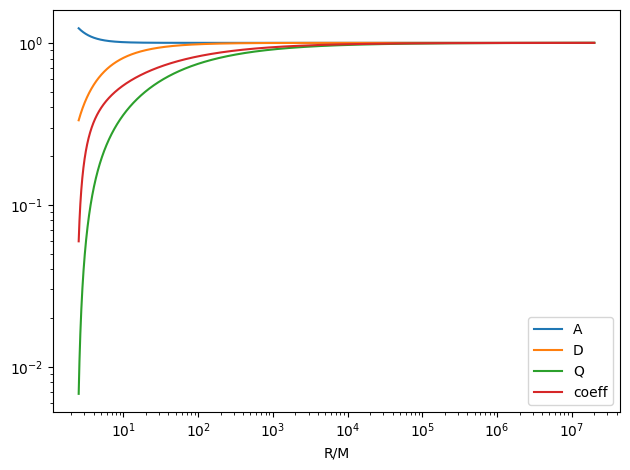

In [39]:


mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps
# mdot=le/eps

disc_solver(4, 0.9, 0.1, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True)

In [ ]:
MBH_power=6
MBH=10**MBH_power * ct.MSun
M=MBH * ct.G /(ct.c*ct.c)
m=MBH/ct.MSun

alpha=0.1
mdot=0.1

r_in_mid=0.5 * (4.5e4)**(10/21) * alpha**(2/21) * m**(2/21) * mdot**(16/21)

r_in_mid=0.5 * (4.5e4)**(10/21) * alpha**(2/21) * m**(2/21) * mdot**(16/21)

print(f"{r_in_mid} Rg")

42.56681945294381 Rg
